# Churn Rate Prediction

The telecom operator Interconnect would like to be able to forecast their churn of clients. If a user is detected as one who is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

[Final presentation](https://drive.google.com/file/d/1MBxPq-Qs6q8R_JUj0RqonW8zPwxVE3bd/view?usp=share_link)

## Content <a id='content'></a>

[Intro](#intro)

[Decomposition](#decomposition)

[Data Upload, Pre-processing and Analysis](#eda)

[EDA summary, open questions and further steps](#open)

[Intermediate discussion results](#mid)

[Final data preprocessing](#preproc)

[Modeling - two-class classification](#ml2)
- [Dummy Classifier](#dc)
- [Modeling functions](#functions)
- [Logistic Regression](#lr)
- [Random Forest](#rf)
- [Keras implementation of Logistic Regression](#nn_lr)
- [Fine-tuning the feature set](#fine)
- [HistGradientBoosting Classifier](#hist)
- [Re-running the models](#rerun)
- [ML intermediate summary](#ml_intermediate)

[UMAP](#umap)

[Constructing a better neural network for the two-class case](#nn)

[Simple three-class neural network](#3class_nn)

[Best model discussion](#best_model)

[Conclusions](#conclusions)

## Intro <a id='intro'></a>

### Interconnect's Services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after the transaction.

### Data

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Model evaluation

The target feature is the `EndDate` column. Primary metric should be considered to be `AUC-ROC`. Additional metric: `Accuracy`.

[Back to Content](#content)

## Decomposition <a id='decomposition'></a>

### Before we start

Before we dive into the project, let's define clearly its scope and goal. To this end, we want to get answers to the questions below, which include both business understandig and initial technical questions, the list of questions is kept plain, even if some questions might seem to be sub-issues of other questions. We will use the already known information and our undertanding of the matter and, if needed, will perform a short research to figure out the answers.

#### Understanding the business

1. Who will be the users of the analysis results?
2. How the users are planning to act on the results? e.g. update the program to be more efficient, propose specific actions to sub-groups of customers?
3. Why this is important? Which dicisions do they plan to make based on the results?
4. How do we define a "churning" customer?
5. What factors should be accounted for? Something industry-specfic? Seasonality?

#### Adding technical details

1. What are the variables which relate most to the task?
2. What kind of data we are dealing with - time series or static?
3. Are there any known issues with the data?
4. What the modeling part is expected to include?
5. How the expected deliverable should look like? 

#### Answers

Based on the already given information on the client and the nature of the task, we can already answer the business questions:

1. Who will be the users of the analysis results? *Marketing Department; they want to be able to forecast their clients planning to leave.*
2. How the users are planning to act on the results? *Offer, supposedly relevant, promotional codes and special plan options.*
3. Why this is important? *The churn is one of the key negative customer value driver and has immediate impact on the bottom line.*
4. How do we define a "churning" customer? *We are dealing with a classification task; namely, a churning customer can be assumed to be the one for whom the probability of churning is estimated to be higher than some thershold, e.g. 0.5.*
5. What factors should be accounted for? *We are working for a communiction services provider, which also proposes cyber security, cloud storage and content streaming services, and basic understanding of the industry can benefit the analysis.*

To answer the technical questions we will proceed with the data upload and EDA. We will formulate questions to the team leader when necessary.

[Back to Content](#content)

## Data upload, Pre-processing and EDA <a id='eda'></a>

### Libraries

In [1]:
import re

import numpy as np
import pandas as pd
import datetime as dt

import math

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import plotly.express as px # advanced plotting
import plotly.graph_objects as go

The main file for us is `contract.csv`, let's start with it.

### `contract.csv`

In [2]:
contract_raw = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract_raw.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


`BeginDate` is a date variable, `EndDate` is of a mixed type, the next three columns seem to be categorical variables. `MonthlyCharges` is correctly detected as a numerical variable, while `TotalCharges` not, which is unexpected. Let's make a close up of the variables.

In [5]:
contract_dtype_dict = {  # presummable types
    f'{contract_raw.columns[3]}': 'category',
    f'{contract_raw.columns[4]}': 'category',
    f'{contract_raw.columns[5]}': 'category',
}

In [6]:
for col in contract_dtype_dict.keys():
    print('Column:', col)
    print(f'{contract_raw[col].value_counts()}\n')

Column: Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Column: PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Column: PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64



In [7]:
mask = pd.to_numeric(contract_raw['TotalCharges'], errors='coerce').isna()
mask.sum()

11

OK, the variables which we assumed as ones that should be categorical (or boolean), are actually. The `TotalCharges` column contains 11 non-numerical values. Given these are 11 observations out of 7043, we will drop them in the following manner:

In [8]:
contract_raw['TotalCharges'] = pd.to_numeric(contract_raw['TotalCharges'], errors = 'coerce')

In [9]:
contract = contract_raw[~contract_raw['TotalCharges'].isna()]

In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


OK, let's read the final contract dataframe.

In [11]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates = [1])

In [12]:
contract = contract.astype(dtype = contract_dtype_dict, errors='ignore')

In [13]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')
contract = contract[~contract_raw['TotalCharges'].isna()]

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   category      
 4   PaperlessBilling  7032 non-null   category      
 5   PaymentMethod     7032 non-null   category      
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(2), object(2)
memory usage: 350.7+ KB


In [15]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Let's check what is the time span of the data, make sure it does not contain duplicates, and visualize how many `customerID`s there are in the dataset for each month:

In [16]:
print(contract.BeginDate.min(), contract.BeginDate.max())

2013-10-01 00:00:00 2020-01-01 00:00:00


In [17]:
len(contract.BeginDate.unique())

76

In [18]:
len(contract.customerID.unique())

7032

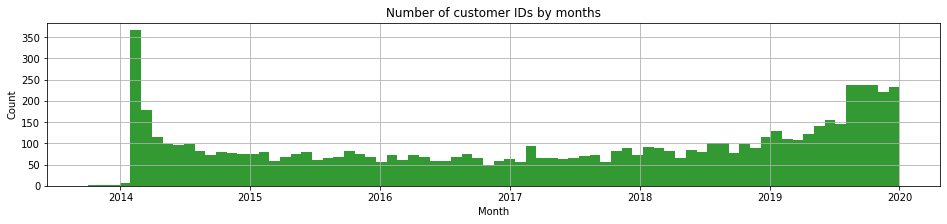

In [19]:
plt.figure(figsize=(16, 3))
contract['BeginDate'].hist(
    color = "green",
    bins = len(contract['BeginDate'].unique()),
    alpha = 0.8
)
plt.title('Number of customer IDs by months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

We have no duplicates by the `customerID` variable and monthly data for 76 months, starting from October 2013 to January 2020. However, we have only a few observations for the first four months, then a spike and then a long period of 50 to 100 new customers per month, until the numbers start grow in 2019. We will have to drop those few observations for the first four months.

In [20]:
contract = contract[contract['BeginDate']>np.datetime64('2014-01')]

Having in mind the modeling, a mixed type columns cannot work; thus, we suggest to parametrize it by break it down the `EndDate` into two columns, one boolean, whether the customer churned or not, and one the life span of `customerID`s with Interconnect. **NOTE:** the `EndDate` column is the target column; thus, we will be able to use its boolean version for a two class classification, while the life span column should be helpful if we go for a multi-class classification.

In [21]:
contract['churn_bool'] = np.where(contract['EndDate']=='No', 0, 1)

In [22]:
contract['last_observed_month'] = np.where(contract['EndDate']!='No',
                                pd.Series(contract['EndDate'], dtype='datetime64'),
                                pd.to_datetime(contract.BeginDate.max()))

Given the data is monthly, we will add the life span in months and use it to prepare a more granular classification - we will create `churn_class` as an alternative target variable, which separates those customers who churned within the first 6 months and those who churn after a longer period. Additionally we will map the `BeginDate` months to their sequence numbers. We will take care of the categorical variables later on, in the Modeling section.

In [23]:
months_map = {}
for i, timestamp in enumerate(contract.sort_values(by='BeginDate').BeginDate.unique()):
    months_map[timestamp] = i+1

In [24]:
contract['begin_month_number'] = contract.BeginDate.map(months_map)

In [25]:
contract['last_observed_month'] = contract['last_observed_month'].map(months_map)

In [26]:
contract['life_span_in_months'] = contract['last_observed_month'] - contract['begin_month_number']

In [27]:
contract['churn_class'] = np.where(
    (contract['churn_bool']==1) & (contract['life_span_in_months']<=6), 1, np.where(
        (contract['churn_bool']==1) & (contract['life_span_in_months']>6), 2, contract['churn_bool']
    )
) 

In [28]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_bool,last_observed_month,begin_month_number,life_span_in_months,churn_class
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,72,72,0,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,72,39,33,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,71,69,2,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,72,28,44,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,70,68,2,1


In [29]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7017 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerID           7017 non-null   object        
 1   BeginDate            7017 non-null   datetime64[ns]
 2   EndDate              7017 non-null   object        
 3   Type                 7017 non-null   category      
 4   PaperlessBilling     7017 non-null   category      
 5   PaymentMethod        7017 non-null   category      
 6   MonthlyCharges       7017 non-null   float64       
 7   TotalCharges         7017 non-null   float64       
 8   churn_bool           7017 non-null   int64         
 9   last_observed_month  7017 non-null   int64         
 10  begin_month_number   7017 non-null   int64         
 11  life_span_in_months  7017 non-null   int64         
 12  churn_class          7017 non-null   int64         
dtypes: category(3), datetime64[ns](1)

Now, let's slice the preprocessed dataframe (choose only relevant variables); we will sort it by the `begin_month_number` and check the value counts of the target variable:

In [30]:
contract_preprocessed = contract[[
    'customerID',
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'MonthlyCharges',
    'TotalCharges',
    'begin_month_number',
    'churn_bool',
    'churn_class',
    'life_span_in_months',
    'last_observed_month',
]].sort_values(by='begin_month_number').reset_index(drop=True)

In [31]:
contract_preprocessed.tail(15)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_month_number,churn_bool,churn_class,life_span_in_months,last_observed_month
7002,9840-EFJQB,Month-to-month,No,Electronic check,74.35,74.35,72,0,0,0,72
7003,8710-YGLWG,Month-to-month,Yes,Mailed check,44.90,44.90,72,0,0,0,72
7004,0021-IKXGC,Month-to-month,Yes,Electronic check,72.10,72.10,72,0,0,0,72
7005,7721-DVEKZ,Month-to-month,No,Mailed check,19.65,19.65,72,0,0,0,72
7006,0082-LDZUE,Month-to-month,Yes,Mailed check,44.30,44.30,72,0,0,0,72
7007,5858-EAFCZ,Month-to-month,No,Mailed check,44.45,44.45,72,0,0,0,72
7008,1628-BIZYP,Month-to-month,Yes,Electronic check,85.00,85.00,72,0,0,0,72
7009,6127-IYJOZ,Month-to-month,Yes,Mailed check,45.85,45.85,72,0,0,0,72
7010,1895-QTKDO,Month-to-month,No,Credit card (automatic),43.95,43.95,72,0,0,0,72
7011,6907-FLBER,Month-to-month,No,Electronic check,54.30,54.30,72,0,0,0,72


In [32]:
contract_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           7017 non-null   object  
 1   Type                 7017 non-null   category
 2   PaperlessBilling     7017 non-null   category
 3   PaymentMethod        7017 non-null   category
 4   MonthlyCharges       7017 non-null   float64 
 5   TotalCharges         7017 non-null   float64 
 6   begin_month_number   7017 non-null   int64   
 7   churn_bool           7017 non-null   int64   
 8   churn_class          7017 non-null   int64   
 9   life_span_in_months  7017 non-null   int64   
 10  last_observed_month  7017 non-null   int64   
dtypes: category(3), float64(2), int64(5), object(1)
memory usage: 459.7+ KB


In [33]:
contract_preprocessed['churn_bool'].value_counts(normalize=True)

0    0.735785
1    0.264215
Name: churn_bool, dtype: float64

In [34]:
contract_preprocessed['churn_class'].value_counts(normalize=True)

0    0.735785
2    0.152487
1    0.111729
Name: churn_class, dtype: float64

As to the target variables, we observe some class imbalance; it is not extreme, like in e.g. rare desease detection problems, and we will check later the need for upsampling. First, let's visualize the churned population. To this end, we will construct a pivot table with the start month as an index and the life span in columns, and count the number of `customerID`s for each intersection. We will take into account only those observations for which the `churn_bool` value is `True`.

In [35]:
contract_pivot = contract_preprocessed[contract_preprocessed['churn_bool']==1].pivot_table(
    index='last_observed_month',
    columns='life_span_in_months',
    values='customerID',
    aggfunc='nunique'
)

Now we introduce a couple of functions to use for the plotting:

In [36]:
def reversed_dict(dct):
    """
    Returns a dictionary with values of the initial dictionart `dct` as keys, and keys as values.
    """
    reversed_dict = {}
    for key in dct:
        reversed_key = dct[key]
        reversed_dict[reversed_key] = key.astype('str')[:7]
    return reversed_dict

In [37]:
def cohort_viz(pivot_df, yticks_mapping = None, fmt = '.0f', title = 'Churn by monthly cohorts',
               xlabel = "Number of months with the company", ylabel = "Churn month", vmin = None, vmax = None):
    """
    A function which takes a cohort pivot table df and visualizes it as a heatmap. For more flexibility, it can take
    a rounding parameter fmt, and a title, an xlabel and a ylabel strings, and yticks labels.
    
    :param pivot_df: source dataframe to visualize.
    :param yticks_mapping: a mapping for the y-axis values to be displayed on the plot.
    :param fmt: the roundig parameter if the sns.heatmap() function.
    :param title: the title parameter if the sns.heatmap() function.
    :param xlabel: the xlabel parameter if the sns.heatmap() function.
    :param fmylabelt: the ylabel parameter if the sns.heatmap() function.
    """
    df=pivot_df.copy()
    if yticks_mapping:
        df.index = df.index.map(yticks_mapping)
    
    plt.figure(figsize=(18, 3))
    plt.title(title)
    
    sns.heatmap(
        data = df, cmap="YlGnBu",
        annot=True,  # drop annotation to not clutter the plot
        fmt=fmt,
        linewidths=2,
        linecolor='lightgray',
        vmin = vmin,
        vmax = vmax,
        cbar = False
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

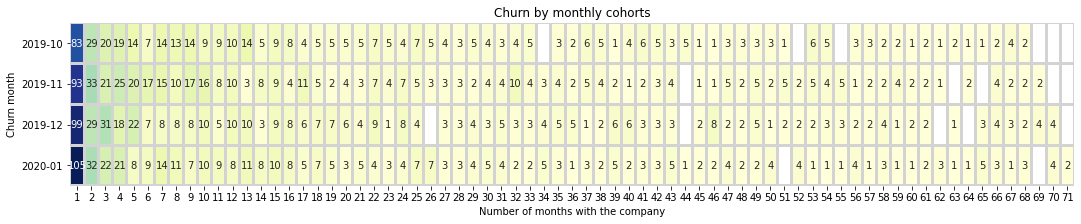

In [38]:
cohort_viz(contract_pivot, reversed_dict(months_map))

One can observe that the data covers only the users who churned in the last four months (Jan 2020, Dec 2019, Nov 2019, and Oct 2019). Using this heatmap, we can see how many customers churned from each cohort, e.g. in Jan 2020, we have 105 cutomers churned from those who signed up for the service in Dec 2019 and 32 of those who signed up in Nov 2019. It looks like customers who had spent less time with the company; however relative numbers whould be studied if such a hypothesis needs to be tested (not the focus of this project).

From the plot of the number of customer IDs by months, we observed a growth in the number of customers starting from 2019, which intensified in the last five months of the observation period; nevertheless, the number of churning customers rose as well; thus, the net number of the customers remained almost unchanged (only the last month showed a shift in the number of the customers who stayed with the company, though we would suggest to be more careful with the data on the last month, which can be preliminary only).

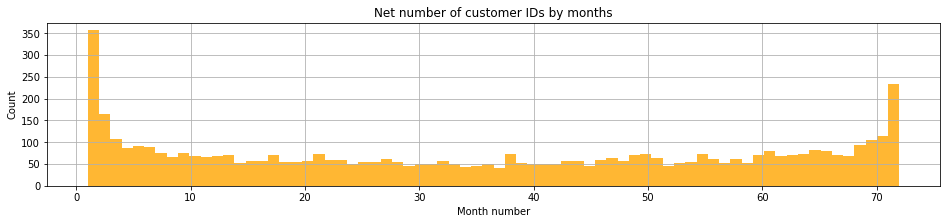

In [39]:
plt.figure(figsize=(16, 3))
contract_preprocessed[contract_preprocessed['churn_bool']==False]['begin_month_number'].hist(
    color = "orange",
    bins = len(contract_preprocessed['begin_month_number'].unique()),
    alpha = 0.8
)
plt.title('Net number of customer IDs by months')
plt.xlabel('Month number')
plt.ylabel('Count')
plt.show()

Let's sum up the observations for the `contract.csv` file and proceed with the rest of the files.

[Back to Content](#content)

Let's try to shed some light on the characteristics of the churning customers.

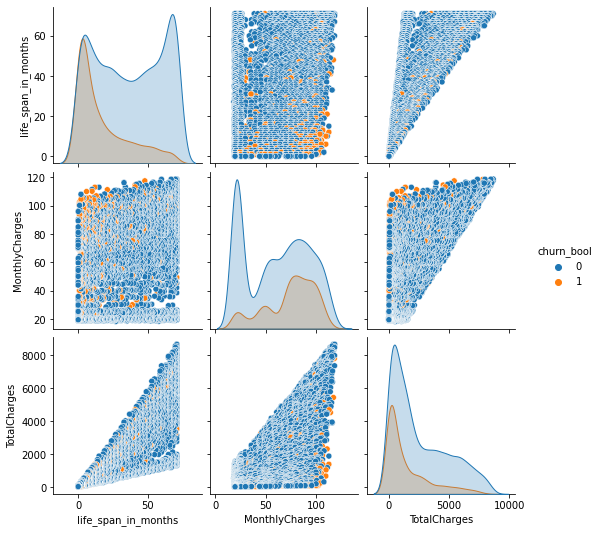

In [40]:
sns.pairplot(contract_preprocessed,vars = ['life_span_in_months','MonthlyCharges','TotalCharges'], hue="churn_bool")
plt.show()

Two observations can be made from this plot:
- less time with the company means easier to leave and...
- ...the higher the monthly charges the more customers tend to leave...
- ...which results in more customers churn with lower total charges record.

#### Summary on `contract.csv`

1. We uploaded the data and analyzed the data types:
- for one float variable we found 11 string observations, which we dropped;
- we found that the data is monthly and there were only few observations for the first four months of the period, we dropped them;
- we parametrized the start and the end date of the contracts by creating `begin_month_number`, `last_observed_month`, and and `life_span_in_months`, as well as `churn_bool` and `churn_class` variables; the first three are technical and only the last of them is supposed to be used as a feature (being essentially a tenure variable), the last two are two variations of the target variable, for two- and three-class modeling.
2. We illustrated the churn process and found that the data cover the churn period of four months, from Oct 2019 to Jan 2020.


3. There was a growth in the number of customers starting from 2019, which intensified in the last five months of the observation period; the number of churning customers rose as well.


4. A pairplot of the charges and the "life span" showed that:
- less time with the company means easier to leave and...
- ...the higher the monthly charges the more customers tend to leave...
- ...which results in more customers churn with lower total charges record.

    Thus, the `TotalCharges` variable, as well as the `begin_month_number` variables can be dropped further down the road.
    
5. The overall class imbalance for the `churn_bool` variable is about 3-to-1 (75% of non-churn customers and 25% of churned); in what follows, we will check the need in the class balancing.

[Back to Content](#content)

### Personal data and use of services

#### `personal.csv`

In [41]:
personal_raw = pd.read_csv('/datasets/final_provider/personal.csv')

In [42]:
personal_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [43]:
personal_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [44]:
for col in personal_raw.columns[1:]:
    print(personal_raw[col].value_counts(), '\n')

Male      3555
Female    3488
Name: gender, dtype: int64 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

No     3641
Yes    3402
Name: Partner, dtype: int64 

No     4933
Yes    2110
Name: Dependents, dtype: int64 



[Back to Content](#content)

#### `internet.csv`

In [45]:
internet_raw = pd.read_csv('/datasets/final_provider/internet.csv')

In [46]:
internet_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [47]:
internet_raw.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [48]:
for col in internet_raw.columns[1:]:
    print(internet_raw[col].value_counts(), '\n')

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64 

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64 

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64 

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64 

No     3473
Yes    2044
Name: TechSupport, dtype: int64 

No     2810
Yes    2707
Name: StreamingTV, dtype: int64 

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64 



[Back to Content](#content)

#### `phone.csv`

In [49]:
phone_raw = pd.read_csv('/datasets/final_provider/phone.csv')

In [50]:
phone_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [51]:
phone_raw.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [52]:
phone_raw.iloc[:,1].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

#### Observations

1. All the variables in these three files are binary categorical/boolean; we will treat them similarly to how we treated such variables in the `contract.csv` file.
2. The number of observations in the `personal.csv` file equals the number of observations in the `contract.csv` file (7043).
3. The two files with service usage cover less `customerID`s: 5517 for the internet services and 6361 for the phone services, which can mean that we will have to build twomodels for two datasets, the one which includes only the contract and the personal data, and the one which includes all the data, however has lower count of observations.

Based on the data structure, we will assume that the information in the source files is static and valid as of the last observation month, i.e. either as of Feb 2020, or as of the month of churn.

[Back to Content](#content)

## Initial Summary, Open Questions and Further Steps <a id='open'></a>

### Summary

Let's check out what answers can we provide now to the technical questions we posed at the beginning.

1. What are the variables which relate most to the task?

We have four source files at our disposal:
- `contract.csv` which icludes variables on the start and the end (if any) contract and some billing information;
- `personal.csv` which includes personal data about the customers - their gender, age group, presence of children and partner status;
- `internet.csv` and `phone.csv` which include boolean variables on usage for different services, though the data cover less customers and there is no indication on the start date of usage (which may be of interest as well).

Up to now, we had no preliminary reason to assume that some variables relate more than others, though it sounds reasonable to suggest that customers who use more services tend to churn less. On the other side, we saw that the most churn happens during the first three months of the contract, when new customers are supposed to mostly sign up for the basic services. Either way, we will see if adding data on services usage results in a model of better quality.

2. What kind of data we are dealing with - time series or static?

We are dealing with cohort data and should carefully consider how to parametrize the problem; a basic model can employ only binary classification, i.e. labels showing whether a customer churned or not; additionaly, we can think how to incorporate the information about the life span until churn.

3. Are there any known issues with the data?

As mentioned above, we discovered the following issues:
- partial data on internet and phone services usage as compared to the number of customer IDs covered by the contract and personal information; no indication on the months customers had singed up for additional services;
- the data cover the churn period of four months, from Oct 2019 to Jan 2020;
- there were more new customers and more churn in the last five months of the period;
- all in all, less time with the company means easier to leave and the higher the monthly charges the more customers tend to leave.

In addition, we assumed that the information in the source files is valid for the last observation month, i.e. either as of Feb 2020, or as of the month of churn.

4. What the modeling part is expected to include?

Regarding the modeling, at the moment, we can assume the following:

- we can try modeling with two datasets, one which includes data from `contract.csv` and from `perdonal.csv` and another one which uses all the source files;
- we can consider the task being a classification problem and use a basic approach, which takes into account only the very fact of churn;
- additionaly, we can try to incorporate the life span until churn, presumably, by considering customers who churned during the first six months and those who churned after a longer period as separate sub-classes; in this case, the task can be treated as three-class classification problem.

As to the model class choice, we will apply Logistic Regression as a base model, then we will try Random Forest, and some variation of a neural network.

The modeling itself will supposedly include:
- finalization of the dataset preprocessing (correct data types assignment, join, categorical variables encoding);
- dataset split into training and testing subsets; validation subset will be extracted for cases whennecessary;
- scaling;
- training a number of models, presumably with cross-validation;
- comparing the models by validation scores, choice of the best model and checking its performance on the test subset.

5. How the expected deliverable should look like?

The delivarable should be two-fold: a notebook, with step-by-step explanations and code, and a presentation for the marketing department.

### Open Questions

The following are the main topics to discuss with the team leader:
1. Overall results of the EDA.
2. Discussion on the nature of the problem - binary classification vs. multi-class classification.

### Next steps

We will proceed in the following order:
1. Finalize the task investigation with the team leader.
2. Finalize the data pre-processing.
3. Develop the modeling part.

Upon completing the modeling part, we will prepare the final report.

[Back to Content](#content)

## Intermediate discussion summary <a id='mid'></a>

As the result of the discussion with the team leader, we:
- stressed the need to prevent data leakage (any `EndDate` based variables are target), avoid multicollinearity while encoding; the way `life_span_in_months` variable calculations was corrected;
- agreed to try two-class and three-class classification models and implement them by means of at least three algorithms - Logistic Regression, Random Forest, and a neural network;
- confirmed that two datasets can be used, one combining the contact and the personal data, another one combining all the data from the four source files; for the latter, missing values will have to be treated and a dimentionality reducing technique can be applied.

[Back to Content](#content)

## Final data preprocessing <a id='preproc'></a>

### Source files final preprocessing

As part of the EDA, we have preprocessed the `contract.csv`, which resulted in the `contract_preprocessed` dataframe:

In the rest of the files, we have one variable, `SeniorCitizen`, already encoded with integers, the rest of the variables have been detected as `object` type, let's turn all of them into `category` and encode them with integers in what follows.

In [53]:
personal_raw['SeniorCitizen'] = personal_raw['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

In [54]:
personal = personal_raw.astype(dtype = {
    'gender': 'category',
    'SeniorCitizen': 'category',
    'Partner': 'category',
    'Dependents': 'category'
}, errors='ignore')

In [55]:
internet_dtype = {}
for col in internet_raw.columns[1:]:
    internet_dtype[col] = 'category'

In [56]:
phone_dtype = {}
for col in phone_raw.columns[1:]:
    phone_dtype[col] = 'category'

In [57]:
internet = internet_raw.astype(dtype=internet_dtype, errors='ignore')

In [58]:
phone = phone_raw.astype(dtype=phone_dtype, errors='ignore')

Let's take a look at the resulting dataframes:

In [59]:
contract_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           7017 non-null   object  
 1   Type                 7017 non-null   category
 2   PaperlessBilling     7017 non-null   category
 3   PaymentMethod        7017 non-null   category
 4   MonthlyCharges       7017 non-null   float64 
 5   TotalCharges         7017 non-null   float64 
 6   begin_month_number   7017 non-null   int64   
 7   churn_bool           7017 non-null   int64   
 8   churn_class          7017 non-null   int64   
 9   life_span_in_months  7017 non-null   int64   
 10  last_observed_month  7017 non-null   int64   
dtypes: category(3), float64(2), int64(5), object(1)
memory usage: 459.7+ KB


In [60]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   category
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


In [61]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   category
 3   OnlineBackup      5517 non-null   category
 4   DeviceProtection  5517 non-null   category
 5   TechSupport       5517 non-null   category
 6   StreamingTV       5517 non-null   category
 7   StreamingMovies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.8+ KB


In [62]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     6361 non-null   object  
 1   MultipleLines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.2+ KB


[Back to Content](#content)

### Combining the preprocessed data into feature datasets and target variable for two-class classification

As mentioned before, we will preform modeling for two datasets, a "basic" one and an "augmented" one. To construct them we will apply the`merge()` function with the default value of the `how` parameter (`inner`). Note: in our basic model we will employ the `churn_bool` column as the target variable; we will also store the customer IDs separately.

#### Basic feature dataset

In [63]:
basic_dataset = contract_preprocessed.iloc[:,:10].merge(personal, on='customerID')

In [64]:
basic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7017 entries, 0 to 7016
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           7017 non-null   object  
 1   Type                 7017 non-null   category
 2   PaperlessBilling     7017 non-null   category
 3   PaymentMethod        7017 non-null   category
 4   MonthlyCharges       7017 non-null   float64 
 5   TotalCharges         7017 non-null   float64 
 6   begin_month_number   7017 non-null   int64   
 7   churn_bool           7017 non-null   int64   
 8   churn_class          7017 non-null   int64   
 9   life_span_in_months  7017 non-null   int64   
 10  gender               7017 non-null   category
 11  SeniorCitizen        7017 non-null   category
 12  Partner              7017 non-null   category
 13  Dependents           7017 non-null   category
dtypes: category(7), float64(2), int64(4), object(1)
memory usage: 487.5+ KB


For the basic dataset, we ended up with 10 features and the same customer IDs which appeared on the final list of the `contract_preprocessed` dataset.

#### Augmented feature dataset

In [65]:
augmented_dataset = basic_dataset.merge(phone, on='customerID').merge(internet, on='customerID')

In [66]:
augmented_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           4818 non-null   object  
 1   Type                 4818 non-null   category
 2   PaperlessBilling     4818 non-null   category
 3   PaymentMethod        4818 non-null   category
 4   MonthlyCharges       4818 non-null   float64 
 5   TotalCharges         4818 non-null   float64 
 6   begin_month_number   4818 non-null   int64   
 7   churn_bool           4818 non-null   int64   
 8   churn_class          4818 non-null   int64   
 9   life_span_in_months  4818 non-null   int64   
 10  gender               4818 non-null   category
 11  SeniorCitizen        4818 non-null   category
 12  Partner              4818 non-null   category
 13  Dependents           4818 non-null   category
 14  MultipleLines        4818 non-null   category
 15  InternetService      

For the augmented dataset, we ended up with 18 features and even less observations that we assumed, 68% of the basic subset, which means that the `internet.csv` source file not only contains data on a smaller subset of contracts, but this subset is partialy different from the customer IDs appearing on the `phone.csv` list.

[Back to Content](#content)

### A note on encoding <a id='encoding_note'></a>

Our plan is to use Logistic Regression, Random Forest and NN models. Besides numerical, our data contained categorical features, while the `sklearn` library we are going to use requires encoding the categorical features (as far as we know, `sklearn` provides [native support for categrical variables](https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt) for [HistGradientBoosting algorithms](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier), which is better for non-ordered categorical data; nevertheless, the categories must be still mapped to integer numbers). There is a basic technique for transforming categorical features into numerical features - One-Hot Encoding (OHE). The OHE creates a separate column for each of the feature values.

On the other hand, we want to utilize a tree based model, and here we have to remember that, unlike regression models, that have access to the whole spectrum of features at once, tree-based models can process only one feature at a time, i.e. a in general case of the OHE, they do not have complete information about the original categorical variable, since it is spreaded across multiple dummy variables. The caveat is that some of these dummy variables can be left unchosen as splitting variables near the root of the tree, even if they were a good predictor. A common way of dealing with this peculiarity is applying label encoding.

Having said that, in our case, we will avoid the caveats of the OHE for tree based models due to another feature of the OHE, namely, potential multicollinearity, or the dummy trap. The dummy trap means appears if, after splitting a category variable into a set of category-based columns, the values of one dummy variable can be inferred from the value of the other dummy variable(s), it is obsolete ans should be omited. For our case of binary categories, it means that a properly designed encoding procedure must create only one column for each variable and choose only one variable value out of the two possibilities.  To implement this type of encoding, we can use the `get_dummies()` function with the `drop_first` parameter equal to `True`.

### Data encoding

In [67]:
def ohe_category(input_df):
    df = input_df.copy()
    df = pd.get_dummies(df, columns=df.dtypes[df.dtypes=='category'].index, drop_first=True)
    return df

In [68]:
basic_dataset_ohe = ohe_category(basic_dataset)

In [69]:
augmented_dataset_ohe = ohe_category(augmented_dataset)

In [70]:
basic_dataset_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7017 entries, 0 to 7016
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7017 non-null   object 
 1   MonthlyCharges                         7017 non-null   float64
 2   TotalCharges                           7017 non-null   float64
 3   begin_month_number                     7017 non-null   int64  
 4   churn_bool                             7017 non-null   int64  
 5   churn_class                            7017 non-null   int64  
 6   life_span_in_months                    7017 non-null   int64  
 7   Type_One year                          7017 non-null   uint8  
 8   Type_Two year                          7017 non-null   uint8  
 9   PaperlessBilling_Yes                   7017 non-null   uint8  
 10  PaymentMethod_Credit card (automatic)  7017 non-null   uint8  
 11  Paym

In [71]:
augmented_dataset_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             4818 non-null   object 
 1   MonthlyCharges                         4818 non-null   float64
 2   TotalCharges                           4818 non-null   float64
 3   begin_month_number                     4818 non-null   int64  
 4   churn_bool                             4818 non-null   int64  
 5   churn_class                            4818 non-null   int64  
 6   life_span_in_months                    4818 non-null   int64  
 7   Type_One year                          4818 non-null   uint8  
 8   Type_Two year                          4818 non-null   uint8  
 9   PaperlessBilling_Yes                   4818 non-null   uint8  
 10  PaymentMethod_Credit card (automatic)  4818 non-null   uint8  
 11  Paym

In [72]:
augmented_dataset_ohe.tail()

,customerID,MonthlyCharges,TotalCharges,begin_month_number,churn_bool,churn_class,life_span_in_months,Type_One year,Type_Two year,PaperlessBilling_Yes,...,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
4813,1628-BIZYP,85.00,85.00,72,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
4814,6127-IYJOZ,45.85,45.85,72,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4815,1895-QTKDO,43.95,43.95,72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4816,6907-FLBER,54.30,54.30,72,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4817,0248-IPDFW,50.10,50.10,72,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


Now, that we have all the data chained and encoded, let's check which of the categorical variables has the most impact. We will count the share of `True` values for the categorical variables at hand for the two groups, of non-churned and churned customers. Then, we will sort the resulting dataframe by `churn_bool==1`  and visualize it as a heat map:

In [73]:
churn_stat = augmented_dataset_ohe.pivot_table(columns='churn_bool', aggfunc='mean').sort_values(by=1)[:-5]

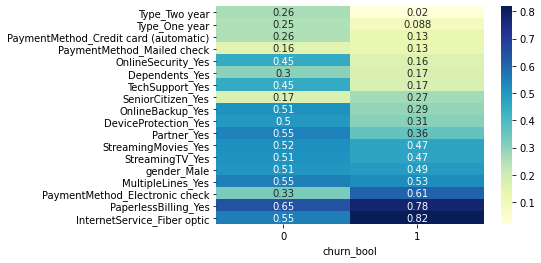

In [74]:
sns.heatmap(
        data = churn_stat, cmap="YlGnBu",
        annot=True)
plt.show()

We can note, that the most difference between those who stay and those who leave can be detected in longer contracts, online security, backup, and tech support, payment methods, age group, existence of a partner, electronic check and optic internet usage variables. There is no difference by gender, phone lines and streaming services. Thus actually, we could drop the `phone` data, `gender` and streaming services from the feature list. We will procede with the datasets as they are at the moment and see whether the following omission of these four variables actually helps.

[Back to Content](#content)

### A note on the data splitting <a id='split_note'></a>

For testing purposes, we need to single out a testing subset. We could go for splitting the two feature sets independently; however, this could result in the training subset of one feature set contain testing observations of the second feature set, and vica versa, which will make the models incomparable; thus, we find that a more desirable solution would be to keep the same testing subset, both for the case the final model will be based on the the "basic" feature set and for the case the final model will work on the "augmented" feature set (or any other feature set we could possibly make use of). In other words, we need the testing subset to include the same customer IDs, both for the "basic" and for the "augmented" feature sets.

To implement this approach, we propose performing a split for the `customerID` and target variable columns of the augmented dataset, and then extracting the feature of the testing subsets by the `customerID` column. The two training subsets will be extracted by `customeID` as well, just for the values which will be not included in the testing subset. We will perform the split with stratifying by the `curn_class` target variable, to preserve the class distributions, and create two separate target variables, for two modeling cases, two- and three-class classification. Let's check the three class distributions and see how balanced are our classes:

In [75]:
basic_dataset_ohe['churn_bool'].value_counts(normalize=True)

0    0.735785
1    0.264215
Name: churn_bool, dtype: float64

In [76]:
augmented_dataset_ohe['churn_bool'].value_counts(normalize=True)

0    0.673724
1    0.326276
Name: churn_bool, dtype: float64

In [77]:
basic_dataset_ohe['churn_class'].value_counts(normalize=True)

0    0.735785
2    0.152487
1    0.111729
Name: churn_class, dtype: float64

In [78]:
augmented_dataset_ohe['churn_class'].value_counts(normalize=True)

0    0.673724
2    0.197177
1    0.129099
Name: churn_class, dtype: float64

The classes are unbalanced and we need to take it into account when splitting, by using the `stratify` parameter of the `train_test_split()` function.

### Splitting the data

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
customerID_augmented_train, customerID_augmented_test = train_test_split(
    augmented_dataset_ohe[['customerID', 'churn_bool', 'churn_class']],
    test_size=0.3,  # we use 0.3 to get account for the larger size of the basic subset
    stratify=augmented_dataset_ohe['churn_class'],
    random_state=54321
)

In [81]:
customerID_augmented_train

,customerID,churn_bool,churn_class
1002,3654-ARMGP,0,0
1334,7401-JIXNM,0,0
3518,3999-QGRJH,1,2
1226,9711-FJTBX,0,0
2524,4412-YLTKF,1,2
...,...,...,...
3264,4298-OYIFC,0,0
2371,6341-JVQGF,0,0
1305,3605-JISKB,0,0
1867,9919-YLNNG,0,0


In [82]:
customerID_train_list = customerID_augmented_train['customerID'].to_list()

In [83]:
customerID_augmented_test

,customerID,churn_bool,churn_class
448,8205-VSLRB,0,0
4521,9546-CQJSU,1,1
1937,9825-YCXWZ,0,0
4578,9747-DDZOS,1,1
2542,5315-CKEQK,0,0
...,...,...,...
4798,4706-DGAHW,0,0
3482,1508-DFXCU,0,0
4033,4763-PGDPO,1,1
283,8766-PAFNE,0,0


In [84]:
customerID_test_list = customerID_augmented_test['customerID'].to_list()

Let's show that the two subsets of the target variable has the same distribution of zero and one values as the initial dataset:

In [85]:
customerID_augmented_train['churn_bool'].value_counts(normalize=True)

0    0.673784
1    0.326216
Name: churn_bool, dtype: float64

In [86]:
customerID_augmented_test['churn_bool'].value_counts(normalize=True)

0    0.673582
1    0.326418
Name: churn_bool, dtype: float64

In [87]:
customerID_augmented_train['churn_class'].value_counts(normalize=True)

0    0.673784
2    0.197212
1    0.129004
Name: churn_class, dtype: float64

In [88]:
customerID_augmented_test['churn_class'].value_counts(normalize=True)

0    0.673582
2    0.197095
1    0.129322
Name: churn_class, dtype: float64

Now we can add the `X_augmented_train` and `X_augmented_test` subsets (we will drop then the, obsolete now, `customerID` variable):

In [89]:
augmented_dataset_ohe_train = augmented_dataset_ohe.copy()
augmented_dataset_ohe_train['test'] = np.where(augmented_dataset_ohe_train['customerID'].isin(customerID_test_list), 1, 0)
augmented_dataset_ohe_test = augmented_dataset_ohe_train.query('test==1')
augmented_dataset_ohe_train = augmented_dataset_ohe_train.query('test==0')

In [90]:
# augmented_dataset_ohe_train

In [91]:
# augmented_dataset_ohe_test

In [92]:
basic_dataset_ohe_train = basic_dataset_ohe.copy()
basic_dataset_ohe_train['test'] = np.where(basic_dataset_ohe_train['customerID'].isin(customerID_test_list), 1, 0)
basic_dataset_ohe_test = basic_dataset_ohe_train.query('test==1')
basic_dataset_ohe_train = basic_dataset_ohe_train.query('test==0')

In [93]:
# basic_dataset_ohe_train

In [94]:
# basic_dataset_ohe_test

In [95]:
X_basic_train = basic_dataset_ohe_train.drop(
    columns=['customerID', 'begin_month_number', 'churn_bool', 'churn_class', 'test']
)
Y_basic_train = basic_dataset_ohe_train['churn_bool']
Y_basic_class_train = basic_dataset_ohe_train['churn_class']

In [96]:
X_basic_test = basic_dataset_ohe_test.drop(
    columns=['customerID', 'begin_month_number', 'churn_bool', 'churn_class', 'test']
)
Y_basic_test = basic_dataset_ohe_test['churn_bool']
Y_basic_class_test = basic_dataset_ohe_test['churn_class']

In [97]:
X_augmented_train = augmented_dataset_ohe_train.drop(
    columns=['customerID', 'begin_month_number', 'churn_bool', 'churn_class', 'test']
)
Y_augmented_train = augmented_dataset_ohe_train['churn_bool']
Y_augmented_class_train = augmented_dataset_ohe_train['churn_class']

In [98]:
X_augmented_test = augmented_dataset_ohe_test.drop(
    columns=['customerID', 'begin_month_number', 'churn_bool', 'churn_class', 'test']
)
Y_augmented_test = augmented_dataset_ohe_test['churn_bool']
Y_augmented_class_test = augmented_dataset_ohe_test['churn_class']

Let's check the indices and shapes:

In [99]:
X_augmented_train.shape, Y_augmented_train.shape

((3372, 21), (3372,))

In [100]:
X_augmented_test.shape, Y_augmented_test.shape

((1446, 21), (1446,))

In [101]:
X_basic_train.shape, Y_basic_train.shape

((5571, 13), (5571,))

In [102]:
X_basic_test.shape, Y_basic_test.shape

((1446, 13), (1446,))

In [103]:
X_augmented_train.index, Y_augmented_train.index

(Int64Index([   1,    2,    6,    7,   13,   14,   15,   16,   17,   18,
             ...
             4804, 4805, 4806, 4807, 4808, 4809, 4812, 4813, 4816, 4817],
            dtype='int64', length=3372),
 Int64Index([   1,    2,    6,    7,   13,   14,   15,   16,   17,   18,
             ...
             4804, 4805, 4806, 4807, 4808, 4809, 4812, 4813, 4816, 4817],
            dtype='int64', length=3372))

In [104]:
X_augmented_test.index, Y_augmented_test.index

(Int64Index([   0,    3,    4,    5,    8,    9,   10,   11,   12,   25,
             ...
             4793, 4794, 4795, 4797, 4798, 4800, 4810, 4811, 4814, 4815],
            dtype='int64', length=1446),
 Int64Index([   0,    3,    4,    5,    8,    9,   10,   11,   12,   25,
             ...
             4793, 4794, 4795, 4797, 4798, 4800, 4810, 4811, 4814, 4815],
            dtype='int64', length=1446))

In [105]:
X_basic_train.index, Y_basic_train.index

(Int64Index([   1,    2,    3,    4,    8,    9,   10,   14,   16,   18,
             ...
             7003, 7005, 7007, 7008, 7011, 7012, 7013, 7014, 7015, 7016],
            dtype='int64', length=5571),
 Int64Index([   1,    2,    3,    4,    8,    9,   10,   14,   16,   18,
             ...
             7003, 7005, 7007, 7008, 7011, 7012, 7013, 7014, 7015, 7016],
            dtype='int64', length=5571))

In [106]:
X_basic_test.index, Y_basic_test.index

(Int64Index([   0,    5,    6,    7,   11,   12,   13,   15,   17,   34,
             ...
             6971, 6972, 6975, 6978, 6985, 6988, 7004, 7006, 7009, 7010],
            dtype='int64', length=1446),
 Int64Index([   0,    5,    6,    7,   11,   12,   13,   15,   17,   34,
             ...
             6971, 6972, 6975, 6978, 6985, 6988, 7004, 7006, 7009, 7010],
            dtype='int64', length=1446))

Let's check the class balance:

In [107]:
Y_basic_train.value_counts(normalize=True)

0    0.75193
1    0.24807
Name: churn_bool, dtype: float64

In [108]:
Y_basic_test.value_counts(normalize=True)

0    0.673582
1    0.326418
Name: churn_bool, dtype: float64

In [109]:
Y_augmented_train.value_counts(normalize=True)

0    0.673784
1    0.326216
Name: churn_bool, dtype: float64

In [110]:
Y_augmented_test.value_counts(normalize=True)

0    0.673582
1    0.326418
Name: churn_bool, dtype: float64

In [111]:
Y_basic_class_train.value_counts(normalize=True)

0    0.751930
2    0.140908
1    0.107162
Name: churn_class, dtype: float64

In [112]:
Y_basic_class_test.value_counts(normalize=True)

0    0.673582
2    0.197095
1    0.129322
Name: churn_class, dtype: float64

In [113]:
Y_augmented_class_train.value_counts(normalize=True)

0    0.673784
2    0.197212
1    0.129004
Name: churn_class, dtype: float64

In [114]:
Y_augmented_class_test.value_counts(normalize=True)

0    0.673582
2    0.197095
1    0.129322
Name: churn_class, dtype: float64

We ended up with approximately the same class balance in the basic train subset, as it is in the basic dataset itself, and, of course, with the same class balance in the augmented train subset, as it is in the augmented dataset.

#### Checking the splitted data

Let's choose a small sample for the target variable in the basic test dataset and check that the corresponding observations appear both in the basic test subset and in the augmented test subset. Since the indices in the basic and in the augmented datasets differ, we will have to find the indices in the augmented dataset which correspond to the the same customer IDs from the basic dataset.

The sample of churned customer indices in the basic test subset:

In [115]:
Y_basic_test[Y_basic_test>0].head()  # check out those which equal 1, i.e. churned customers

167    1
365    1
367    1
411    1
499    1
Name: churn_bool, dtype: int64

Indices of the observations in the sample above:

In [116]:
indices_from_test = Y_basic_test[Y_basic_test>0].head().index

The full observations for the indices above:

In [117]:
basic_dataset_ohe[basic_dataset_ohe.index.isin(indices_from_test)].T # churned customers

,167,365,367,411,499
customerID,1265-XTECC,4853-RULSV,4550-VBOFE,6481-OGDOO,5502-RLUYV
MonthlyCharges,96.55,104.0,102.95,90.6,103.95
TotalCharges,6581.9,7250.15,7101.5,6056.15,7446.9
begin_month_number,1,1,2,2,2
churn_bool,1,1,1,1,1
churn_class,2,2,2,2,2
life_span_in_months,68,70,70,67,69
Type_One year,1,0,0,1,0
Type_Two year,0,1,0,0,0
PaperlessBilling_Yes,1,1,1,1,1


[Back to Content](#content)

The same observation in the basic test subset feature dataframe:

In [118]:
X_basic_test[X_basic_test.index.isin(indices_from_test)].T

,167,365,367,411,499
MonthlyCharges,96.55,104.00,102.95,90.60,103.95
TotalCharges,6581.90,7250.15,7101.50,6056.15,7446.90
life_span_in_months,68.00,70.00,70.00,67.00,69.00
Type_One year,1.00,0.00,0.00,1.00,0.00
Type_Two year,0.00,1.00,0.00,0.00,0.00
PaperlessBilling_Yes,1.00,1.00,1.00,1.00,1.00
PaymentMethod_Credit card (automatic),1.00,1.00,0.00,1.00,0.00
PaymentMethod_Electronic check,0.00,0.00,1.00,0.00,1.00
PaymentMethod_Mailed check,0.00,0.00,0.00,0.00,0.00
gender_Male,0.00,1.00,1.00,1.00,0.00


Cutomer IDs for the indices above:

In [119]:
cutomer_ids_from_basic_test =  basic_dataset_ohe[basic_dataset_ohe.index.isin(
        Y_basic_test[Y_basic_test>0].head().index  
    )]['customerID'].to_list()

In [120]:
cutomer_ids_from_basic_test

['1265-XTECC', '4853-RULSV', '4550-VBOFE', '6481-OGDOO', '5502-RLUYV']

The full observations for the customer IDs above in the augmented dataset:

In [121]:
augmented_dataset_ohe[augmented_dataset_ohe['customerID'].isin(cutomer_ids_from_basic_test)].T

,129,268,270,302,362
customerID,1265-XTECC,4853-RULSV,4550-VBOFE,6481-OGDOO,5502-RLUYV
MonthlyCharges,96.55,104.0,102.95,90.6,103.95
TotalCharges,6581.9,7250.15,7101.5,6056.15,7446.9
begin_month_number,1,1,2,2,2
churn_bool,1,1,1,1,1
churn_class,2,2,2,2,2
life_span_in_months,68,70,70,67,69
Type_One year,1,0,0,1,0
Type_Two year,0,1,0,0,0
PaperlessBilling_Yes,1,1,1,1,1


Indices of the customer IDs from `Y_basic_test` subset in the augmented dataset:

In [122]:
indx_basic_in_augmented = augmented_dataset_ohe[augmented_dataset_ohe['customerID'].isin(cutomer_ids_from_basic_test)].index

In [123]:
indx_basic_in_augmented

Int64Index([129, 268, 270, 302, 362], dtype='int64')

The same observations in the augmented test subset feature dataframe:

In [124]:
X_augmented_test[X_augmented_test.index.isin(indx_basic_in_augmented)].T

,129,268,270,302,362
MonthlyCharges,96.55,104.00,102.95,90.60,103.95
TotalCharges,6581.90,7250.15,7101.50,6056.15,7446.90
life_span_in_months,68.00,70.00,70.00,67.00,69.00
Type_One year,1.00,0.00,0.00,1.00,0.00
Type_Two year,0.00,1.00,0.00,0.00,0.00
PaperlessBilling_Yes,1.00,1.00,1.00,1.00,1.00
PaymentMethod_Credit card (automatic),1.00,1.00,0.00,1.00,0.00
PaymentMethod_Electronic check,0.00,0.00,1.00,0.00,1.00
PaymentMethod_Mailed check,0.00,0.00,0.00,0.00,0.00
gender_Male,0.00,1.00,1.00,1.00,0.00


### Intermediate results

Out results by this moment:
- we have two encoded datasets: basic and augmented...
- ... splitted into training and test subsets...
- ...while the test subsets, in the basic and augmented versions, are for the same customer IDs.

Now, we are set to proceed and construct the models.

[Back to Content](#content)

## Modeling - two-class classification <a id='ml2'></a>

### ML libraries

In [125]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict  # for hyperparameter tuning

from scipy.stats import randint as sp_randint  # for initializing random integer values for the needs of hyperparameter tuning
from scipy.stats import loguniform

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

### Score

We were requested to use `AUC-ROC` as the primary metric and `accuracy` as additional metric. NOTE: usually [formulating a business problem as an ML task requires an extensive work of the team](https://www.superdatascience.com/podcast/getting-the-most-out-of-data-with-gradient-boosting) to establish a proper metric, while for the purposes of this project we were adviced about the metric in advance.

### Model statistics

To follow up with the model performance, we will manage two model statistics dictionaries:

In [126]:
model_stat_basic = {
    'model_name': [],
    'roc_auc_score': [],
    'accuracy_score': []
}

In [127]:
model_stat_augmented = {
    'model_name': [],
    'roc_auc_score': [],
    'accuracy_score': []
}

To populate the dictionary, we will employ the following function:

In [128]:
def append_model_stats(stats_dict, model_name, roc_auc_score_value, acuracy_score_value):
    stats_dict['model_name'].append(model_name)
    stats_dict['roc_auc_score'].append(roc_auc_score_value)
    stats_dict['accuracy_score'].append(acuracy_score_value)
    
    return stats_dict

### DummyClassifier as a Baseline <a id='dc'></a>

Let's establich a baseline for our models to compare the ir quality with to. To this end, we will use a sklearn Dummy Classifier and employ it with `strategy` parameter value `stratified`. In our case, that will mean that the classifier will predict that there is a 25% probability for the basic dataset and a 33% probability for the augmented dataset that each customer object it encounters churned.

In [129]:
from sklearn.dummy import DummyClassifier

To make our code repeatable for the two datasets, we will wrap up the model into a function.

In [130]:
def dummy_model(X,y):
    
    dummy_model = DummyClassifier(strategy="stratified")
    dummy_model.fit(X,y)
    dummy_predictions = dummy_model.predict(X)
    print(f'ROC_AUC score: {roc_auc_score(y, dummy_predictions):.2f}')
    print(f'Mean accuracy score: {dummy_model.score(X, y):.2f}')
    print(f'Frequency of each class observed in the target: {dummy_model.class_prior_}')
    
    return dummy_model

In [131]:
dummy_basic = dummy_model(X_basic_train, Y_basic_train)

ROC_AUC score: 0.50
Mean accuracy score: 0.63
Frequency of each class observed in the target: [0.75192964 0.24807036]


In [132]:
dummy_augmented = dummy_model(X_augmented_train, Y_augmented_train)

ROC_AUC score: 0.50
Mean accuracy score: 0.57
Frequency of each class observed in the target: [0.6737841 0.3262159]


The dummy model shows correct predictions for 62% of observations in the basic training dataset and for 57% of observations in the augmented dataset. The `ROC_AUC` metric, as expected, equals 0.5.

Let's document these results:

In [133]:
append_model_stats(
    model_stat_basic,
    'Dummy Classifier',
    roc_auc_score(Y_basic_train, dummy_basic.predict(X_basic_train)),
    dummy_basic.score(X_basic_train, Y_basic_train)
)

{'model_name': ['Dummy Classifier'],
 'roc_auc_score': [0.5129854774357346],
 'accuracy_score': [0.6253814395979178]}

In [134]:
append_model_stats(
    model_stat_augmented,
    'Dummy Classifier',
    roc_auc_score(Y_augmented_train, dummy_augmented.predict(X_augmented_train)),
    dummy_basic.score(X_augmented_train, Y_augmented_train)
)

{'model_name': ['Dummy Classifier'],
 'roc_auc_score': [0.49720550576184386],
 'accuracy_score': [0.5925266903914591]}

Now, when we established a baseline, we can proceed with our first candidate model, Logistic Regression.

[Back to Content](#content)

### Modeling functions <a id='functions'></a>

Note: we will rely on the `MinMaxScaler()` method to normalize the data and preserve their meaning.

We will construct a universal function to run all the models; besides the model (or pipe specification) specification it will be able to display or not to display a confusion matrix from cross-validated predictions as additional metric for model quality in view of the class imbalance.

In [135]:
def run_model(model_spec, X, y, cross_val_count=10, to_scale=True, display_confusion_matrix=False):
    if to_scale:
        model_scaler = MinMaxScaler()
        model_pipe = Pipeline([('scaler', model_scaler), ('model', model_spec)])
    else:
        model_pipe = Pipeline([('model', model_spec)])
    model_scores = cross_validate(model_pipe, X, y, scoring = ['roc_auc', 'accuracy', 'recall'], cv=cross_val_count)
    print(f'{model_spec} results:')
    for key in (model_scores):
        print(f'{key}: {[x*10000//100/100 for x in model_scores[key]]}')
    print(f"average roc_auc score: {model_scores['test_roc_auc'].mean():.2f}")
    print(f"average accuracy score: {model_scores['test_accuracy'].mean():.2f}")
    print(f"average recall score: {model_scores['test_recall'].mean():.2f}")
    
    if display_confusion_matrix: 
        y_pred = cross_val_predict(model_pipe, X, y, cv=cross_val_count)
        cm = confusion_matrix(y, y_pred, normalize='all')
        print(f"confusion matrix:")
        disp = ConfusionMatrixDisplay(cm)
        disp.plot();
    
    return model_scores

Let's also add a function to use for the winning model testing:

In [136]:
def (test_modelmodel_spec, X_train, y_train, X_test, y_test, to_scale=True, display_confusion_matrix=False):
    if to_scale:
        model_scaler = MinMaxScaler()
        model_pipe = Pipeline([('scaler', model_scaler), ('model', model_spec)])
    else:
        model_pipe = Pipeline([('model', model_spec)])
        
    model_pipe.fit(X_train, y_train)
    y_pred_proba = model_pipe.predict_proba(X_test)[::,1]
    y_predict = model_pipe.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_predict)
    
    print(f'{model_spec} results:')
    print(f"test roc_auc score: {auc:.2f}")
    print(f"test accuracy score: {accuracy:.2f}")
    
    if display_confusion_matrix: 
        cm = confusion_matrix(y_test, y_predict, normalize='all')
        print(f"confusion matrix:")
        disp = ConfusionMatrixDisplay(cm)
        disp.plot();

### Logistic Regression model <a id='lr'></a>

LogisticRegression() results:
fit_time: [0.01, 0.01, 0.06, 0.01, 0.06, 0.01, 0.06, 0.01, 0.06, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.94, 0.95, 0.94, 0.95, 0.9, 0.89, 0.86, 0.79, 0.76, 0.69]
test_accuracy: [0.75, 0.77, 0.83, 0.86, 0.84, 0.85, 0.8, 0.73, 0.69, 0.65]
test_recall: [0.0, 0.09, 0.34, 0.5, 0.56, 0.68, 0.57, 0.57, 0.64, 0.59]
average roc_auc score: 0.87
average accuracy score: 0.78
average recall score: 0.46
confusion matrix:


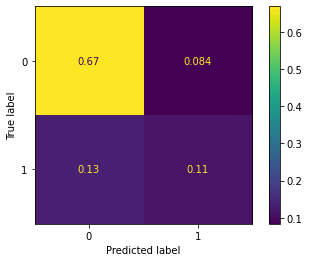

In [137]:
lr_basic_scores = run_model(LogisticRegression(), X_basic_train, Y_basic_train, display_confusion_matrix=True)

LogisticRegression() results:
fit_time: [0.01, 0.04, 0.01, 0.06, 0.01, 0.01, 0.01, 0.01, 0.06, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.94, 0.94, 0.96, 0.94, 0.91, 0.9, 0.88, 0.78, 0.77, 0.67]
test_accuracy: [0.67, 0.7, 0.81, 0.86, 0.85, 0.83, 0.8, 0.66, 0.63, 0.56]
test_recall: [0.0, 0.1, 0.44, 0.6, 0.64, 0.81, 0.8, 0.73, 0.8, 0.76]
average roc_auc score: 0.87
average accuracy score: 0.74
average recall score: 0.57
confusion matrix:


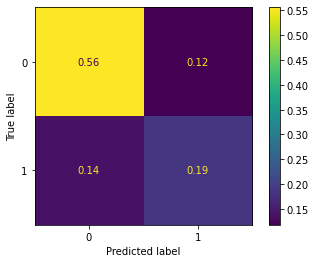

In [138]:
lr_augmented_scores = run_model(LogisticRegression(), X_augmented_train, Y_augmented_train, display_confusion_matrix=True)

### Imbalance impact assessment

From the first run, we can make two observations:
1. The ratio between true negatives and true posititves is becomes more skewed in favour the true negatives as far as the imbalance grows (we remember that the imbalance in the latter is 3:1, i.e. 75% of non-churned customers and 25% churned, vs. 2:1 ration for in the former);
2. A more equal distribution of `FN`s and `FP`s for the "augmented dataset" and a higher share of `FN`s than `FP` for the "basic" dataset.

Besides the better prediction of true negatives, we should remember, that for the problem at hand, the false negatives seems to comprise more of a challenge: if we fail to predict that a customer is going to churn, we miss the chance to make him/her an offer which, in turn, could prompt them to stay. On the other hand, false positives mean detecting customers who are not going to leave as those ready to do so; in general, making a more attractive offer to those customers, thus shrinking the margin on them, can have its impact on the bottom line as well. We can assume that for a telcom company, as one with significant amount of capital investments, it is more profitable to have more paying customers; thus, tackling the false negatives should be more important for them.

#### Balancing with `class_weight` parameter

Let's run the Logistic Regression model with the `class_weight` parameter value `balanced` and compare the results.

LogisticRegression(class_weight='balanced') results:
fit_time: [0.02, 0.02, 0.04, 0.01, 0.06, 0.01, 0.07, 0.01, 0.06, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.94, 0.94, 0.93, 0.94, 0.9, 0.89, 0.86, 0.79, 0.76, 0.69]
test_accuracy: [0.75, 0.86, 0.87, 0.85, 0.77, 0.68, 0.69, 0.6, 0.53, 0.35]
test_recall: [0.02, 0.55, 0.81, 0.87, 0.86, 0.94, 0.91, 0.91, 0.89, 0.97]
average roc_auc score: 0.87
average accuracy score: 0.70
average recall score: 0.78
confusion matrix:


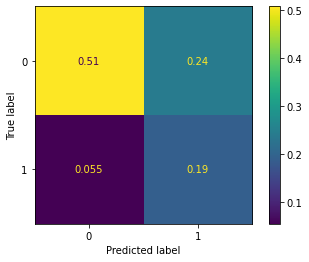

In [139]:
lr_balanced_basic_scores = run_model(
    LogisticRegression(class_weight='balanced'),
    X_basic_train,
    Y_basic_train,
    display_confusion_matrix=True
)

LogisticRegression(class_weight='balanced') results:
fit_time: [0.01, 0.06, 0.02, 0.07, 0.02, 0.07, 0.02, 0.06, 0.02, 0.07]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.95, 0.94, 0.96, 0.94, 0.91, 0.9, 0.88, 0.78, 0.77, 0.67]
test_accuracy: [0.67, 0.78, 0.93, 0.89, 0.79, 0.67, 0.7, 0.55, 0.51, 0.38]
test_recall: [0.0, 0.35, 0.82, 0.84, 0.86, 0.89, 0.86, 0.85, 0.92, 0.99]
average roc_auc score: 0.87
average accuracy score: 0.69
average recall score: 0.74
confusion matrix:


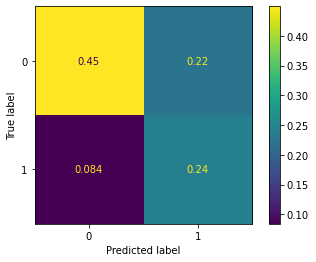

In [140]:
lr_balanced_augmented_scores = run_model(
    LogisticRegression(class_weight='balanced'),
    X_augmented_train,
    Y_augmented_train,
    display_confusion_matrix=True
)

By balancing the classes with the `class_weight` parameter, we achieved much better `recall` score values, without deteriorating the `roc_auc` score values and with minor decrease in `accuracy` value, while in general the true negatives and the true positives count ratio reflects the class weights in the training datasets.

#### SMOTE

As an alternative, we can try applying the `SMOTE` technique of the `imblearn` library to treat the imbalance; doing this results will also result in reducing the false negatives count at the cost of false positives, thus, improving the `recall_score`. Let's apply SMOTE to reduce the class imbalance and compare with the previous results.  To this end, we will need to modify the `run_model()` function and use the [pipeline constructor of the `imblearn`](https://imbalanced-learn.org/stable/auto_examples/pipeline/plot_pipeline_classification.html) (Imbalanced Learn library).

In [141]:
# pip install --user imblearn

In [142]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [143]:
def run_model_with_smote(model_spec, X, y, cross_val_count=10, to_scale=True, display_confusion_matrix=False):
    smote = SMOTE()
    model = model_spec
    if to_scale:
        model_scaler = MinMaxScaler()
        model_pipe = make_pipeline(smote, model_scaler, model)
    else:
        model_pipe = make_pipeline(smote, model)
    model_scores = cross_validate(model_pipe, X, y, scoring = ['roc_auc', 'accuracy', 'recall'], cv=cross_val_count)
    print(f'{model_spec} results:')
    for key in (model_scores):
        print(f'{key}: {[x*10000//100/100 for x in model_scores[key]]}')
    print(f"average roc_auc score: {model_scores['test_roc_auc'].mean():.2f}")
    print(f"average accuracy score: {model_scores['test_accuracy'].mean():.2f}")
    print(f"average recall score: {model_scores['test_recall'].mean():.2f}")
    
    if display_confusion_matrix: 
        y_pred = cross_val_predict(model_pipe, X, y, cv=cross_val_count)
        cm = confusion_matrix(y, y_pred, normalize='all')
        print(f"confusion matrix:")
        disp = ConfusionMatrixDisplay(cm)
        disp.plot();
    
    return model_scores

LogisticRegression() results:
fit_time: [0.04, 0.06, 0.08, 0.08, 0.08, 0.08, 0.04, 0.03, 0.1, 0.07]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0]
test_roc_auc: [0.92, 0.9, 0.9, 0.9, 0.88, 0.86, 0.83, 0.76, 0.72, 0.64]
test_accuracy: [0.75, 0.84, 0.85, 0.83, 0.78, 0.72, 0.71, 0.66, 0.58, 0.41]
test_recall: [0.01, 0.45, 0.68, 0.73, 0.84, 0.85, 0.84, 0.81, 0.81, 0.9]
average roc_auc score: 0.84
average accuracy score: 0.72
average recall score: 0.70
confusion matrix:


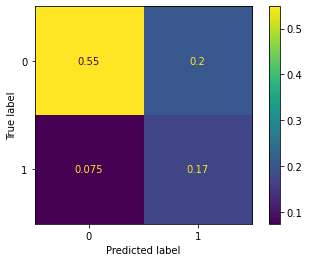

In [144]:
lr_basic_smote_scores = run_model_with_smote(
    LogisticRegression(),
    X_basic_train,
    Y_basic_train,
    display_confusion_matrix=True
)

LogisticRegression() results:
fit_time: [0.13, 0.03, 0.03, 0.08, 0.08, 0.08, 0.08, 0.03, 0.03, 0.08]
score_time: [0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0]
test_roc_auc: [0.93, 0.89, 0.92, 0.9, 0.87, 0.88, 0.85, 0.78, 0.76, 0.67]
test_accuracy: [0.67, 0.79, 0.85, 0.85, 0.81, 0.75, 0.74, 0.61, 0.56, 0.45]
test_recall: [0.0, 0.36, 0.59, 0.68, 0.74, 0.85, 0.84, 0.82, 0.87, 0.93]
average roc_auc score: 0.85
average accuracy score: 0.71
average recall score: 0.67
confusion matrix:


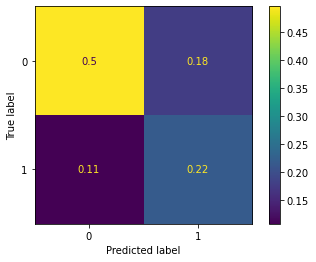

In [145]:
lr_augmented_smote_scores = run_model_with_smote(
    LogisticRegression(),
    X_augmented_train,
    Y_augmented_train,
    display_confusion_matrix=True
)

From these two results, we can observe that the total count of the false negatives diminished; the ratio of true negatives and true positives similar to that in the training dataset; the `roc_auc` and the `accuracy` scores deteriorated. Unfortunately, applying SMOTE results in models of lower quality than when using the `calss_weight` parameter.

NOTE: this small case study of the impact of imbalanced classes demonstrates the importance of three sources of bias and low model quality:
1. untreated imbalance between the data classes;
2. ultimate choice of metrics (should reflect the true meaning of the task for the business);
3. the method used to balance the unbalanced.

For the needs of this project we were asked to focus on the `roc_auc` and `accuracy` metrics; thus, in what follows, we will draw our conclusions based on these two metrics, while balancing the data with `class_weight` parameter of the models.

Let's document the results up to this moment:

In [146]:
append_model_stats(
    model_stat_basic,
    'Logistic Regression | unbalanced',
    lr_basic_scores['test_roc_auc'].mean(),
    lr_basic_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier', 'Logistic Regression | unbalanced'],
 'roc_auc_score': [0.5129854774357346, 0.8722941158843002],
 'accuracy_score': [0.6253814395979178, 0.7819118678532588]}

In [147]:
append_model_stats(
    model_stat_augmented,
    'Logistic Regression | unbalanced',
    lr_augmented_scores['test_roc_auc'].mean(),
    lr_augmented_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier', 'Logistic Regression | unbalanced'],
 'roc_auc_score': [0.49720550576184386, 0.873610156749503],
 'accuracy_score': [0.5925266903914591, 0.7426167190490405]}

In [148]:
append_model_stats(
    model_stat_basic,
    'Logistic Regression | balanced',
    lr_balanced_basic_scores['test_roc_auc'].mean(),
    lr_balanced_basic_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced'],
 'roc_auc_score': [0.5129854774357346, 0.8722941158843002, 0.8692207550119265],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256]}

In [149]:
append_model_stats(
    model_stat_augmented,
    'Logistic Regression | balanced',
    lr_balanced_augmented_scores['test_roc_auc'].mean(),
    lr_balanced_augmented_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced'],
 'roc_auc_score': [0.49720550576184386, 0.873610156749503, 0.8730907088506207],
 'accuracy_score': [0.5925266903914591,
  0.7426167190490405,
  0.6918494196969431]}

In [150]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912


In [151]:
pd.DataFrame(model_stat_augmented).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.497206,0.592527
2,Logistic Regression | balanced,0.873091,0.691849
1,Logistic Regression | unbalanced,0.873610,0.742617


Interestingly, we can observe substantial growth in the `AUC-ROC` metric value and noticable growth in the accuracy metric. Let's check whether we can improve the model with hyperparameter tuning:

In [152]:
def modify_dict(input_dict, modification_string, side='left', left_trim=0, right_trim=0):
    output_dict = {}
    for key in input_dict:
        if side=='left':
            output_key = f'{modification_string}{key}'
        elif side=='right':
            output_key = f'{key}{modification_string}'
        else:
            print('The `side` parameter defined incorrectly, no modification is made.')
            return input_dict
        
        output_key = output_key[left_trim:(len(output_key)-right_trim)]
        output_dict[output_key] = input_dict[key]
    
    return output_dict

In [153]:
def tune_model(model, X, y, param_space):
    model_scaler = MinMaxScaler()
    pipe = Pipeline([('scaler', model_scaler), ('model', model)])
    
    model_param_space = modify_dict(param_space, 'model__')
    
    rs = RandomizedSearchCV(
        pipe,
        param_distributions = model_param_space,
        scoring={
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy',
        },
        n_iter=50,
        cv = 10,
        random_state=42,
        refit='roc_auc'
    )
    
    rs.fit(X,y)
    
    print(f'Best parameters: {rs.best_params_}')
    print(f'Best score: {rs.best_score_}')
    
    return rs

In [154]:
lr_param_space = {
    'class_weight': ['balanced'],
    'random_state': [42],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Note: FitFailedWarning will araise for incompatibale solver-penalty pairs 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': loguniform(1e-5, 100)
}

In [155]:
rs_lr_basic = tune_model(LogisticRegression(class_weight='balanced'), X_basic_train, Y_basic_train, lr_param_space)

Best parameters: {'model__C': 0.004185822729546973, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__random_state': 42, 'model__solver': 'liblinear'}
Best score: 0.874748174518768


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.

In [156]:
rs_lr_basic.best_params_

{'model__C': 0.004185822729546973,
 'model__class_weight': 'balanced',
 'model__penalty': 'l1',
 'model__random_state': 42,
 'model__solver': 'liblinear'}

In [157]:
lr_basic_best_model = LogisticRegression(**modify_dict(rs_lr_basic.best_params_, '', left_trim=len('model__')))

In [158]:
lr_basic_scores_tuned = run_model(lr_basic_best_model, X_basic_train, Y_basic_train)

LogisticRegression(C=0.004185822729546973, class_weight='balanced',
                   penalty='l1', random_state=42, solver='liblinear') results:
fit_time: [0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.9, 0.94, 0.91, 0.92, 0.89, 0.9, 0.91, 0.87, 0.84, 0.62]
test_accuracy: [0.75, 0.8, 0.75, 0.75, 0.71, 0.71, 0.74, 0.68, 0.64, 0.35]
test_recall: [0.0, 0.49, 0.55, 0.58, 0.58, 0.59, 0.53, 0.55, 0.81, 0.76]
average roc_auc score: 0.87
average accuracy score: 0.69
average recall score: 0.55


Let's document this result:

In [159]:
append_model_stats(
    model_stat_basic,
    'Logistic Regression | balanced | tuned',
    lr_basic_scores_tuned['test_roc_auc'].mean(),
    lr_basic_scores_tuned['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned'],
 'roc_auc_score': [0.5129854774357346,
  0.8722941158843002,
  0.8692207550119265,
  0.874748174518768],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256,
  0.6930429270992194]}

In [160]:
rs_lr_augmented = tune_model(LogisticRegression(), X_augmented_train, Y_augmented_train, lr_param_space)

Best parameters: {'model__C': 0.09416777190511023, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__random_state': 42, 'model__solver': 'liblinear'}
Best score: 0.8836340274996664


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.

In [161]:
rs_lr_augmented.best_params_

{'model__C': 0.09416777190511023,
 'model__class_weight': 'balanced',
 'model__penalty': 'l1',
 'model__random_state': 42,
 'model__solver': 'liblinear'}

The hyperparameter set is slightly different from that of the basic dataset (for the `C` parameter).

In [162]:
lr_augmented_best_model = LogisticRegression(**modify_dict(rs_lr_augmented.best_params_, '', left_trim=len('model__')))

In [163]:
lr_augmented_scores_tuned = run_model(lr_augmented_best_model, X_augmented_train, Y_augmented_train)

LogisticRegression(C=0.09416777190511023, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear') results:
fit_time: [0.03, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.03, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.95, 0.94, 0.96, 0.94, 0.92, 0.91, 0.9, 0.82, 0.8, 0.67]
test_accuracy: [0.67, 0.8, 0.93, 0.91, 0.79, 0.68, 0.69, 0.58, 0.52, 0.37]
test_recall: [0.0, 0.39, 0.82, 0.85, 0.86, 0.92, 0.89, 0.92, 0.93, 0.99]
average roc_auc score: 0.88
average accuracy score: 0.70
average recall score: 0.76


Let's document this result as well:

In [164]:
append_model_stats(
    model_stat_augmented,
    'Logistic Regression | balanced | tuned',
    lr_augmented_scores_tuned['test_roc_auc'].mean(),
    lr_augmented_scores_tuned['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned'],
 'roc_auc_score': [0.49720550576184386,
  0.873610156749503,
  0.8730907088506207,
  0.8836340274996664],
 'accuracy_score': [0.5925266903914591,
  0.7426167190490405,
  0.6918494196969431,
  0.6986717117623302]}

Let's overview the results which have been generated until now:

In [165]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912
3,Logistic Regression | balanced | tuned,0.874748,0.693043


In [166]:
pd.DataFrame(model_stat_augmented).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.497206,0.592527
2,Logistic Regression | balanced,0.873091,0.691849
1,Logistic Regression | unbalanced,0.873610,0.742617
3,Logistic Regression | balanced | tuned,0.883634,0.698672


The Regression Classifier works a little bit better with the augmented dataset.

Reminder: we are still in the two-class classification)

Let's proceed with the Random Forest models.

[Back to Content](#content)

### Random Forest <a id='rf'></a>

In [167]:
rf_basic_scores = run_model(RandomForestClassifier(class_weight='balanced'), X_basic_train, Y_basic_train)

RandomForestClassifier(class_weight='balanced') results:
fit_time: [0.35, 0.37, 0.36, 0.36, 0.37, 0.35, 0.36, 1.01, 0.66, 0.37]
score_time: [0.02, 0.02, 0.03, 0.02, 0.03, 0.02, 0.05, 0.09, 0.02, 0.02]
test_roc_auc: [0.65, 0.33, 0.37, 0.37, 0.44, 0.52, 0.55, 0.71, 0.69, 0.67]
test_accuracy: [0.75, 0.7, 0.68, 0.63, 0.59, 0.56, 0.61, 0.6, 0.46, 0.29]
test_recall: [0.0, 0.0, 0.0, 0.03, 0.15, 0.2, 0.49, 0.86, 0.92, 1.0]
average roc_auc score: 0.53
average accuracy score: 0.59
average recall score: 0.37


In [168]:
rf_augmented_scores = run_model(RandomForestClassifier(class_weight='balanced'), X_augmented_train, Y_augmented_train)

RandomForestClassifier(class_weight='balanced') results:
fit_time: [0.25, 0.25, 0.28, 0.25, 0.25, 0.26, 0.27, 0.25, 0.25, 0.25]
score_time: [0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
test_roc_auc: [0.72, 0.3, 0.41, 0.47, 0.37, 0.37, 0.55, 0.58, 0.61, 0.66]
test_accuracy: [0.67, 0.64, 0.63, 0.56, 0.5, 0.44, 0.57, 0.52, 0.44, 0.32]
test_recall: [0.0, 0.0, 0.01, 0.02, 0.1, 0.25, 0.48, 0.72, 0.86, 1.0]
average roc_auc score: 0.51
average accuracy score: 0.53
average recall score: 0.35


In [169]:
append_model_stats(
    model_stat_basic,
    'Random Forest | balanced',
    rf_basic_scores['test_roc_auc'].mean(),
    rf_basic_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced'],
 'roc_auc_score': [0.5129854774357346,
  0.8722941158843002,
  0.8692207550119265,
  0.874748174518768,
  0.5349447816453472],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256,
  0.6930429270992194,
  0.5916066613900632]}

In [170]:
append_model_stats(
    model_stat_augmented,
    'Random Forest | balanced',
    rf_augmented_scores['test_roc_auc'].mean(),
    rf_augmented_scores['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced'],
 'roc_auc_score': [0.49720550576184386,
  0.873610156749503,
  0.8730907088506207,
  0.8836340274996664,
  0.5092687453013791],
 'accuracy_score': [0.5925266903914591,
  0.7426167190490405,
  0.6918494196969431,
  0.6986717117623302,
  0.5340298140572051]}

The results are even worst than for the dymmy classifier. Let's try tuning the hyperparameters.

In [171]:
rf_param_space = {
    "class_weight": ['balanced'],
    "max_depth": range(2,10),
    "min_samples_split": sp_randint(2, 10),
    "min_samples_leaf": sp_randint(2, 30),
    "max_leaf_nodes": sp_randint(2,50),
    "bootstrap": [True, False],
    "n_estimators": sp_randint(20,100),
    "max_features": ['sqrt', 'log2', None]
}

In [172]:
rs_rf_basic = tune_model(RandomForestClassifier(), X_basic_train, Y_basic_train, rf_param_space)

Best parameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 28, 'model__min_samples_leaf': 26, 'model__min_samples_split': 5, 'model__n_estimators': 96}
Best score: 0.8229657276138742


In [173]:
rs_rf_basic.best_params_

{'model__bootstrap': True,
 'model__class_weight': 'balanced',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': 28,
 'model__min_samples_leaf': 26,
 'model__min_samples_split': 5,
 'model__n_estimators': 96}

In [174]:
rf_basic_best_model = RandomForestClassifier(**modify_dict(rs_rf_basic.best_params_, '', left_trim=len('model__')))

In [175]:
rf_basic_scores_tuned = run_model(rf_basic_best_model, X_basic_train, Y_basic_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=28,
                       min_samples_leaf=26, min_samples_split=5,
                       n_estimators=96) results:
fit_time: [0.15, 0.14, 0.15, 0.14, 0.14, 0.14, 0.15, 0.15, 0.17, 0.14]
score_time: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01]
test_roc_auc: [0.9, 0.87, 0.83, 0.84, 0.81, 0.82, 0.81, 0.77, 0.77, 0.74]
test_accuracy: [0.75, 0.74, 0.78, 0.79, 0.65, 0.6, 0.6, 0.51, 0.33, 0.26]
test_recall: [0.0, 0.02, 0.5, 0.57, 0.85, 0.94, 0.93, 0.93, 0.99, 1.0]
average roc_auc score: 0.82
average accuracy score: 0.61
average recall score: 0.68


Let's add this result to our model statistics:

In [176]:
append_model_stats(
    model_stat_basic,
    'Random Forest | balanced | tuned',
    rf_basic_scores_tuned['test_roc_auc'].mean(),
    rf_basic_scores_tuned['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned'],
 'roc_auc_score': [0.5129854774357346,
  0.8722941158843002,
  0.8692207550119265,
  0.874748174518768,
  0.5349447816453472,
  0.8207862135921546],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256,
  0.6930429270992194,
  0.5916066613900632,
  0.6066874513362033]}

The results is better than before tuning the model; however, still worse than for the tuned Logistic Regression model.

In [177]:
rs_rf_augmented = tune_model(RandomForestClassifier(), X_augmented_train, Y_augmented_train, rf_param_space)

Best parameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 28, 'model__min_samples_leaf': 26, 'model__min_samples_split': 5, 'model__n_estimators': 96}
Best score: 0.8206051472293068


In [178]:
rs_rf_augmented.best_params_

{'model__bootstrap': True,
 'model__class_weight': 'balanced',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': 28,
 'model__min_samples_leaf': 26,
 'model__min_samples_split': 5,
 'model__n_estimators': 96}

In [179]:
rf_augmented_best_model = RandomForestClassifier(**modify_dict(rs_rf_augmented.best_params_, '', left_trim=len('model__')))

In [180]:
rf_augmented_scores_tuned = run_model(rf_augmented_best_model, X_augmented_train, Y_augmented_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=28,
                       min_samples_leaf=26, min_samples_split=5,
                       n_estimators=96) results:
fit_time: [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12]
score_time: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01]
test_roc_auc: [0.9, 0.86, 0.89, 0.87, 0.82, 0.85, 0.81, 0.76, 0.71, 0.7]
test_accuracy: [0.67, 0.67, 0.67, 0.78, 0.71, 0.61, 0.51, 0.4, 0.33, 0.32]
test_recall: [0.0, 0.0, 0.0, 0.43, 0.76, 0.97, 0.98, 1.0, 1.0, 1.0]
average roc_auc score: 0.82
average accuracy score: 0.57
average recall score: 0.62


In [181]:
append_model_stats(
    model_stat_augmented,
    'Random Forest | balanced | tuned',
    rf_augmented_scores_tuned['test_roc_auc'].mean(),
    rf_augmented_scores_tuned['test_accuracy'].mean()
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned'],
 'roc_auc_score': [0.49720550576184386,
  0.873610156749503,
  0.8730907088506207,
  0.8836340274996664,
  0.5092687453013791,
  0.8218589588207603],
 'accuracy_score': [0.5925266903914591,
  0.7426167190490405,
  0.6918494196969431,
  0.6986717117623302,
  0.5340298140572051,
  0.5722999666391587]}

The overall results until now:

In [182]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
4,Random Forest | balanced,0.534945,0.591607
5,Random Forest | balanced | tuned,0.820786,0.606687
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912
3,Logistic Regression | balanced | tuned,0.874748,0.693043


In [183]:
pd.DataFrame(model_stat_augmented).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.497206,0.592527
4,Random Forest | balanced,0.509269,0.534030
5,Random Forest | balanced | tuned,0.821859,0.572300
2,Logistic Regression | balanced,0.873091,0.691849
1,Logistic Regression | unbalanced,0.873610,0.742617
3,Logistic Regression | balanced | tuned,0.883634,0.698672


So far, the tuned Logistic Regression resulted in best outcomes, although the Random Forest tuned model with `class_weight='balanced'` also resulted in much better `roc_auc` score. Just out of curiousity, let's check the Random Forest model with SMOTE-balanced data instead of balancing it through the `class_weight` parameter:

In [184]:
rf_augmented_smote_scores = run_model_with_smote(
    RandomForestClassifier(),
    X_augmented_train,
    Y_augmented_train
)

RandomForestClassifier() results:
fit_time: [0.33, 0.34, 0.33, 0.41, 0.33, 0.32, 0.33, 0.34, 0.32, 0.31]
score_time: [0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02]
test_roc_auc: [0.74, 0.39, 0.46, 0.52, 0.42, 0.44, 0.54, 0.61, 0.61, 0.65]
test_accuracy: [0.67, 0.63, 0.62, 0.57, 0.5, 0.48, 0.55, 0.51, 0.39, 0.32]
test_recall: [0.0, 0.03, 0.05, 0.1, 0.21, 0.41, 0.53, 0.77, 0.87, 1.0]
average roc_auc score: 0.54
average accuracy score: 0.53
average recall score: 0.40


In [185]:
def tune_model_with_smote(model, X, y, param_space, to_scale=True):
    smote = SMOTE()
    ml = model
    if to_scale:
        model_scaler = MinMaxScaler()
        pipe = make_pipeline(smote, model_scaler, ml)
    else:
        pipe = make_pipeline(smote, ml)
    
    model_param_space = modify_dict(param_space, f'{str(model).lower()[:-2]}__')
    
    rs = RandomizedSearchCV(
        pipe,
        param_distributions = model_param_space,
        scoring={
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy',
        },
        n_iter=50,
        cv = 10,
        random_state=42,
        refit='roc_auc'
    )
    
    rs.fit(X,y)
    
    print(f'Best parameters: {rs.best_params_}')
    print(f'Best score: {rs.best_score_}')
    
    return rs

In [186]:
rs_rf_smote_augmented = tune_model_with_smote(RandomForestClassifier(), X_augmented_train, Y_augmented_train, rf_param_space)

Best parameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_leaf_nodes': 42, 'randomforestclassifier__min_samples_leaf': 16, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 84}
Best score: 0.8156658867834384


In [187]:
rs_rf_smote_augmented.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 2,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': 42,
 'randomforestclassifier__min_samples_leaf': 16,
 'randomforestclassifier__min_samples_split': 6,
 'randomforestclassifier__n_estimators': 84}

In [188]:
rf_smote_augmented_best_model = RandomForestClassifier(**modify_dict(
    rs_rf_augmented.best_params_,
    '',
    left_trim=len('model__')
))

In [189]:
rf_augmented_smote_scores_tuned = run_model_with_smote(rf_smote_augmented_best_model, X_augmented_train, Y_augmented_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=28,
                       min_samples_leaf=26, min_samples_split=5,
                       n_estimators=96) results:
fit_time: [0.15, 0.15, 0.15, 0.13, 0.13, 0.14, 0.13, 0.15, 0.13, 0.13]
score_time: [0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
test_roc_auc: [0.89, 0.86, 0.89, 0.86, 0.81, 0.83, 0.8, 0.79, 0.74, 0.68]
test_accuracy: [0.67, 0.67, 0.67, 0.78, 0.72, 0.61, 0.6, 0.46, 0.32, 0.33]
test_recall: [0.0, 0.0, 0.0, 0.38, 0.67, 0.9, 0.9, 0.99, 1.0, 0.99]
average roc_auc score: 0.82
average accuracy score: 0.59
average recall score: 0.59


Tuning the Random Forest model with SMOTE sampling in the pipeline, instead of using the `class_weight` parameter, resulted in only minor improvement in the accuracy score.

[Back to Content](#content)

### Keras implementation of Logistic Regression <a id='nn_lr'></a>

#### Introducing class weightening with validation split

In [190]:
from tensorflow import keras

We will start with a simple model of implementing the Logistic Regression with `keras`. Note: we will implement the class weightening by defining the metrics as weighted_metrics in the `model.compile()` method, which means the scores will be weighted by the weights defined in the `class_weight` parameter of the `model.fit()` method (see an example [here](https://keras.io/examples/structured_data/imbalanced_classification/)); the `class_weight` parameter receives a class weight dictionary, which should be defined statically, presumably, based on the target variable distribution in the training set. We should be aware that applying the `validation_split` does not preserve the class distribution, while the class weights in the dictionary cannot be recalculated after the splitting. Thus, one could conclude that by defining the class weight dictionary based on the whole training set, before the split, we end up with both inaccurate estimate of the class weights and, to some degree, with target leakage. In fact, defining the class weights is a quite arbitrary task: as we have mentioned before, in cases with high cost of false negatives, one should put more weight on the rare class, even beyond the ratio dictated by the training set; thus, no direct dependency between the validation set class distribution and the `class_weight` dictionary can be assumed. Nevertheless, we propose running the model using the `validation_split` parameter, first, and estimate the need in the additional split of the training set into training and validation data.

In [191]:
def keras_lr(X,y):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.25}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=1, input_dim=X.shape[1], activation='sigmoid'
        )
    )
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X, y, epochs=300, verbose=1, validation_split=0.2, shuffle=True, class_weight=class_weight_dict)
    
    return model.history

The data must be scaled before passing it into the model:

In [192]:
def min_max_scale(df, col_name):
    df[col_name] = (df[col_name] - df[col_name].min(axis=0)) / (df[col_name].max(axis=0) - df[col_name].min(axis=0))
    return df

In [193]:
X_basic_train_normalized = X_basic_train.copy()

In [194]:
for col in X_basic_train_normalized.columns.to_list()[:3]:
    min_max_scale(X_basic_train_normalized, col)

In [195]:
X_basic_train_normalized

,MonthlyCharges,TotalCharges,life_span_in_months,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes
1,0.068227,0.206528,1.0,0,1,1,1,0,0,1,1,0,0
2,0.050299,0.187083,1.0,1,0,1,0,0,0,0,0,1,1
3,0.950199,0.945170,1.0,0,1,1,1,0,0,0,0,1,0
4,0.853586,0.874446,1.0,0,1,0,1,0,0,1,0,1,1
8,0.608566,0.668694,1.0,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7012,0.010458,0.000058,0.0,0,0,1,0,0,1,1,0,0,1
7013,0.014442,0.000105,0.0,0,0,0,0,0,1,1,0,1,1
7014,0.012450,0.000082,0.0,0,0,1,0,0,1,0,0,0,0
7015,0.317231,0.003650,0.0,0,0,1,0,1,0,0,0,0,0


In [196]:
keras_lr_basic = keras_lr(X_basic_train_normalized, Y_basic_train)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Model summary: None


2022-11-07 07:51:48.151907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
140/140 [==============================] - 1s 3ms/step - loss: 1.2712 - auc: 0.6008 - accuracy: 0.5788 - val_loss: 0.6959 - val_auc: 0.5417 - val_accuracy: 0.5166
Epoch 2/300
140/140 [==============================] - 0s 2ms/step - loss: 1.2596 - auc: 0.6111 - accuracy: 0.5790 - val_loss: 0.6924 - val_auc: 0.5456 - val_accuracy: 0.5166
Epoch 3/300
140/140 [==============================] - 0s 1ms/step - loss: 1.2487 - auc: 0.6211 - accuracy: 0.5788 - val_loss: 0.6893 - val_auc: 0.5571 - val_accuracy: 0.5157
Epoch 4/300
140/140 [==============================] - 0s 2ms/step - loss: 1.2385 - auc: 0.6321 - accuracy: 0.5791 - val_loss: 0.6864 - val_auc: 0.5674 - val_accuracy: 0.5489
Epoch 5/300
140/140 [==============================] - 0s 2ms/step - loss: 1.2287 - auc: 0.6421 - accuracy: 0.5851 - val_loss: 0.6837 - val_auc: 0.5789 - val_accuracy: 0.5713
Epoch 6/300
140/140 [==============================] - 0s 2ms/step - loss: 1.2195 - auc: 0.6521 - accuracy: 0.5943 - val_loss

Let's check the structure of the `History` object:

In [197]:
keras_lr_basic.history.keys()

dict_keys(['loss', 'auc', 'accuracy', 'val_loss', 'val_auc', 'val_accuracy'])

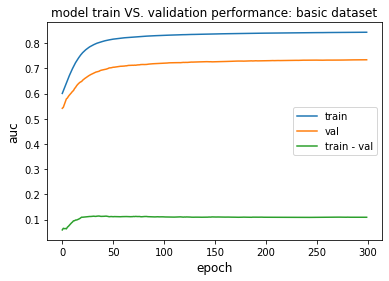

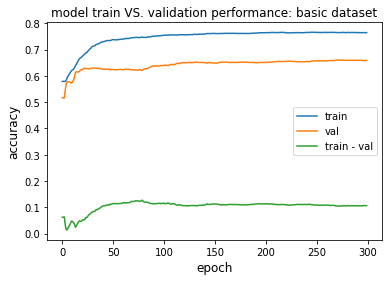

In [198]:
metrics_basic = ["auc", 'accuracy']
for metric in metrics_basic:
    plt.figure()
    plt.plot(keras_lr_basic.history[metric])
    plt.plot(keras_lr_basic.history["val_" + metric])
    plt.plot([x - y for (x,y) in zip(keras_lr_basic.history[metric], keras_lr_basic.history["val_" + metric])])
    plt.title("model train VS. validation performance: basic dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

We can see how the training accuracy and `roc_auc` reach their limit after 200 epochs. By observing the validation scores, we can see how, the network does not benefit significantly from training after 150 epochs; the model never reaches similar metric value for both the validation and the training `roc_auc` and it does not overfit (if we continue the training, the validation accuracy does not start decreasing). Overall performance of the network is very poor.

For our model statistics we can take last values of `AUC` and `acurracy` on the validation subset:

In [199]:
append_model_stats(
    model_stat_basic,
    'Keras Logistic Regression | balanced | val_split',
    keras_lr_basic.history[f'val_{metrics_basic[0]}'][-1],
    keras_lr_basic.history[f'val_{metrics_basic[1]}'][-1]
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_split'],
 'roc_auc_score': [0.5129854774357346,
  0.8722941158843002,
  0.8692207550119265,
  0.874748174518768,
  0.5349447816453472,
  0.8207862135921546,
  0.7342633008956909],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256,
  0.6930429270992194,
  0.5916066613900632,
  0.6066874513362033,
  0.6582959890365601]}

In [200]:
X_augmented_train_normalized = X_augmented_train.copy()

In [201]:
for col in X_augmented_train_normalized.columns.to_list()[:3]:
    min_max_scale(X_augmented_train_normalized, col)

In [202]:
keras_lr_augmented = keras_lr(X_augmented_train_normalized, Y_augmented_train)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 22        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/300
85/85 [==============================] - 1s 4ms/step - loss: 1.3515 - auc_1: 0.6488 - accuracy: 0.6007 - val_loss: 0.6657 - val_auc_1: 0.6215 - val_accuracy: 0.6133
Epoch 2/300
85/85 [==============================] - 0s 2ms/step - loss: 1.3459 - auc_1: 0.6532 - accuracy: 0.6056 - val_loss: 0.6641 - val_auc_1: 0.6243 - val_accuracy: 0.6133
Epoch 3/300
85/85 [==============================] - 0s 2ms/step - loss: 1.3402 - auc_1: 0.6574 - accuracy: 0.6109 - val_loss: 0.6627 - val_auc_1: 0.6256 - val_accuracy: 0.6133
Epo

In [203]:
keras_lr_augmented.history.keys()

dict_keys(['loss', 'auc_1', 'accuracy', 'val_loss', 'val_auc_1', 'val_accuracy'])

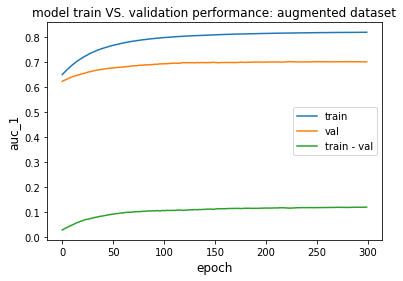

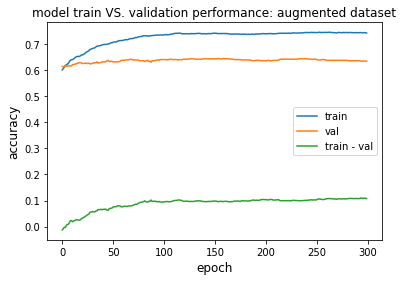

In [204]:
metrics_augmented = ["auc_1", 'accuracy']
for metric in metrics_augmented:
    plt.figure()
    plt.plot(keras_lr_augmented.history[metric])
    plt.plot(keras_lr_augmented.history["val_" + metric])
    plt.plot([x - y for (x,y) in zip(keras_lr_augmented.history[metric], keras_lr_augmented.history["val_" + metric])])
    plt.title("model train VS. validation performance: augmented dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

As in the case of the basic dataset, we can take the last values of the validation metrics for the model stats purposes.

In [205]:
append_model_stats(
    model_stat_augmented,
    'Keras Logistic Regression | balanced | val_split',
    keras_lr_augmented.history[f'val_{metrics_augmented[0]}'][-1],
    keras_lr_augmented.history[f'val_{metrics_augmented[1]}'][-1]
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_split'],
 'roc_auc_score': [0.49720550576184386,
  0.873610156749503,
  0.8730907088506207,
  0.8836340274996664,
  0.5092687453013791,
  0.8218589588207603,
  0.6996924877166748],
 'accuracy_score': [0.5925266903914591,
  0.7426167190490405,
  0.6918494196969431,
  0.6986717117623302,
  0.5340298140572051,
  0.5722999666391587,
  0.6340740919113159]}

In [206]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
4,Random Forest | balanced,0.534945,0.591607
6,Keras Logistic Regression | balanced | val_split,0.734263,0.658296
5,Random Forest | balanced | tuned,0.820786,0.606687
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912
3,Logistic Regression | balanced | tuned,0.874748,0.693043


In [207]:
pd.DataFrame(model_stat_augmented).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.497206,0.592527
4,Random Forest | balanced,0.509269,0.534030
6,Keras Logistic Regression | balanced | val_split,0.699692,0.634074
5,Random Forest | balanced | tuned,0.821859,0.572300
2,Logistic Regression | balanced,0.873091,0.691849
1,Logistic Regression | unbalanced,0.873610,0.742617
3,Logistic Regression | balanced | tuned,0.883634,0.698672


#### Applying class weightening with validation data

The basic `keras` implementation of the Logistic Regression worked better with the "basic" feature set, so we will check how the model perfomes when, for the validation purposes, we employ explicitely defined validation dataset.

In [208]:
X_basic_train_normalized_t, X_basic_train_normalized_v, Y_basic_train_t, Y_basic_train_v = train_test_split(
    X_basic_train_normalized,
    Y_basic_train,
    test_size=0.2,  
    stratify=Y_basic_train,
    random_state=54321
)

In [209]:
def keras_lr_with_val_data(X_t,y_t, X_v, Y_v):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.25}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=1, input_dim=X_t.shape[1], activation='sigmoid'
        )
    )
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X_t, y_t, epochs=300, verbose=1, validation_data=(X_v, Y_v), shuffle=True, class_weight=class_weight_dict)
    
    return model.history

In [210]:
keras_lr_basic_with_val_data = keras_lr_with_val_data(
    X_basic_train_normalized_t,
    Y_basic_train_t,
    X_basic_train_normalized_v,
    Y_basic_train_v
)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/300
140/140 [==============================] - 1s 3ms/step - loss: 1.7652 - auc_2: 0.4243 - accuracy: 0.4973 - val_loss: 1.1019 - val_auc_2: 0.4315 - val_accuracy: 0.2825
Epoch 2/300
140/140 [==============================] - 0s 1ms/step - loss: 1.7307 - auc_2: 0.4278 - accuracy: 0.4974 - val_loss: 1.0703 - val_auc_2: 0.4365 - val_accuracy: 0.2861
Epoch 3/300
140/140 [==============================] - 0s 2ms/step - loss: 1.6983 - auc_2: 0.4329 - accuracy: 0.4980 - val_loss: 1.0405 - val_auc_2: 0.4421 - val_accuracy: 0.28

In [211]:
keras_lr_basic_with_val_data.history.keys()

dict_keys(['loss', 'auc_2', 'accuracy', 'val_loss', 'val_auc_2', 'val_accuracy'])

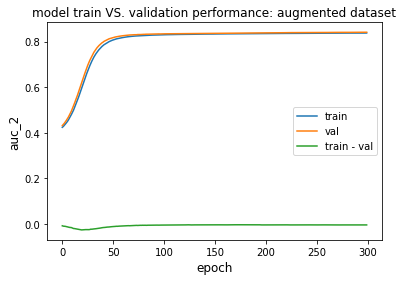

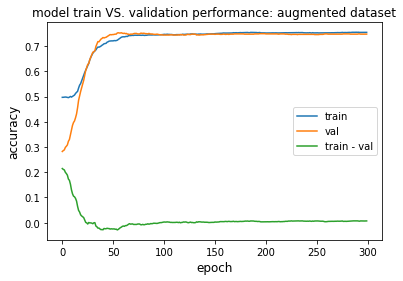

In [212]:
metrics_basic_with_val_data = ["auc_2", 'accuracy']
for metric in metrics_basic_with_val_data:
    plt.figure()
    plt.plot(keras_lr_basic_with_val_data.history[metric])
    plt.plot(keras_lr_basic_with_val_data.history["val_" + metric])
    plt.plot([x - y for (x,y) in zip(keras_lr_basic_with_val_data.history[metric], keras_lr_basic_with_val_data.history["val_" + metric])])
    plt.title("model train VS. validation performance: augmented dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

When feeding explicitely splitted training and validation subsets into the neural network with class weightening, we achieved similar, and much better, scores on both subsets:

In [213]:
append_model_stats(
    model_stat_basic,
    'Keras Logistic Regression | balanced | val_data',
    keras_lr_basic_with_val_data.history[f'val_{metrics_basic_with_val_data[0]}'][-1],
    keras_lr_basic_with_val_data.history[f'val_{metrics_basic_with_val_data[1]}'][-1]
)

{'model_name': ['Dummy Classifier',
  'Logistic Regression | unbalanced',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_split',
  'Keras Logistic Regression | balanced | val_data'],
 'roc_auc_score': [0.5129854774357346,
  0.8722941158843002,
  0.8692207550119265,
  0.874748174518768,
  0.5349447816453472,
  0.8207862135921546,
  0.7342633008956909,
  0.8407545685768127],
 'accuracy_score': [0.6253814395979178,
  0.7819118678532588,
  0.7013001679504256,
  0.6930429270992194,
  0.5916066613900632,
  0.6066874513362033,
  0.6582959890365601,
  0.7479820847511292]}

In [214]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
4,Random Forest | balanced,0.534945,0.591607
6,Keras Logistic Regression | balanced | val_split,0.734263,0.658296
5,Random Forest | balanced | tuned,0.820786,0.606687
7,Keras Logistic Regression | balanced | val_data,0.840755,0.747982
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912
3,Logistic Regression | balanced | tuned,0.874748,0.693043


Still, the `keras` implementation of Logistic Regressions performs weaker that the `sklearn` Logistic Regression. We will try to build a more sophisticated NN, but first let's try a bit different approach. We will:
1. Employ [`sklearn.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)...
2. ... make use of one of its features, the capability to deal with the NaN values.

Thus, we will be able to use one, combined, dataset, with missing values for some features. In addition, we will:

3. Drop that four variables mentioned above which does not explain variability between the two classes;
4. Use min max scaling for the only numerical feature we keep in use, `MonthlyCharges`.

Note: the support for `class_weight` is going to be available only in [version 1.2](https://github.com/scikit-learn/scikit-learn/pull/22014).

Let's prepare this "fine-tuned" feature set.

[Back to Content](#content)

### Fine-tuning the dataset <a id='fine'></a>

Let's prepare the training feature dataset. We remember, that one of the variables to drop is `MultipleLines`, the only one in the `phone.csv`; thus, we can start with re-rendering the initial dataset from the "basic" dataset and the `internet.csv` file.

In [215]:
full_train_dataset = basic_dataset[~basic_dataset_ohe['customerID'].isin(
    customerID_test_list
)].merge(internet, on='customerID', how='left')

In [216]:
full_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5571 entries, 0 to 5570
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           5571 non-null   object  
 1   Type                 5571 non-null   category
 2   PaperlessBilling     5571 non-null   category
 3   PaymentMethod        5571 non-null   category
 4   MonthlyCharges       5571 non-null   float64 
 5   TotalCharges         5571 non-null   float64 
 6   begin_month_number   5571 non-null   int64   
 7   churn_bool           5571 non-null   int64   
 8   churn_class          5571 non-null   int64   
 9   life_span_in_months  5571 non-null   int64   
 10  gender               5571 non-null   category
 11  SeniorCitizen        5571 non-null   category
 12  Partner              5571 non-null   category
 13  Dependents           5571 non-null   category
 14  InternetService      4051 non-null   category
 15  OnlineSecurity       

Now, let's drop the last month observations (we have shown earlier that the data on the last month can be preliminary in terms of the churn rate), the rest of the columns we discussed as less important: first, the streaming services and the gender, than `begin_month_number` which classifies the customers in too small cohorts; we have a less granular variable with more business sense - `life_span_in_months` instead. Of course, we also drop `customerID`, a non-explanotory variable,.

In [218]:
last_begin_month_number = full_train_dataset['begin_month_number'].max()
full_train_dataset = full_train_dataset.query('begin_month_number < @last_begin_month_number')

In [219]:
full_train_dataset_short = full_train_dataset.drop(
    columns=['customerID', 'begin_month_number', 'StreamingTV', 'StreamingMovies', 'gender']
)

In [220]:
full_train_dataset_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 5371
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Type                 5372 non-null   category
 1   PaperlessBilling     5372 non-null   category
 2   PaymentMethod        5372 non-null   category
 3   MonthlyCharges       5372 non-null   float64 
 4   TotalCharges         5372 non-null   float64 
 5   churn_bool           5372 non-null   int64   
 6   churn_class          5372 non-null   int64   
 7   life_span_in_months  5372 non-null   int64   
 8   SeniorCitizen        5372 non-null   category
 9   Partner              5372 non-null   category
 10  Dependents           5372 non-null   category
 11  InternetService      3960 non-null   category
 12  OnlineSecurity       3960 non-null   category
 13  OnlineBackup         3960 non-null   category
 14  DeviceProtection     3960 non-null   category
 15  TechSupport          

Let's check that we do not have outiers in the `TotalCharges` variable. To this end, we will take a look at the 1% of the highest `TotalCharges` values:

In [221]:
full_train_dataset_short[full_train_dataset_short['TotalCharges'] > full_train_dataset_short['TotalCharges'].quantile(0.99)]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_bool,churn_class,life_span_in_months,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport
2,Two year,Yes,Credit card (automatic),113.65,8124.20,0,0,71,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes
14,Two year,Yes,Credit card (automatic),112.75,8192.60,0,0,71,No,No,No,Fiber optic,Yes,Yes,Yes,Yes
18,Two year,Yes,Credit card (automatic),117.15,8529.50,0,0,71,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes
39,Two year,Yes,Bank transfer (automatic),114.95,8196.40,0,0,71,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes
40,Two year,No,Bank transfer (automatic),111.95,8033.10,0,0,71,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes
47,Two year,Yes,Electronic check,115.50,8425.15,0,0,71,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes
55,Two year,Yes,Credit card (automatic),110.65,8065.65,0,0,71,No,Yes,No,Fiber optic,Yes,Yes,Yes,No
66,Two year,Yes,Credit card (automatic),110.90,8240.85,0,0,71,No,Yes,No,Fiber optic,Yes,No,Yes,Yes
86,Two year,Yes,Credit card (automatic),115.75,8399.15,0,0,71,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes
88,Two year,Yes,Credit card (automatic),116.75,8277.05,0,0,71,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes


The upper 1% of the customers by `TotalCharges` are those who have a long track record with the company and signed up for all the internet services; thus, there is no reason to assume any outliers.

Now, we will scale numerical variables:

In [222]:
full_train_dataset_short_scaled = full_train_dataset_short.copy()
min_max_scale(full_train_dataset_short_scaled, 'MonthlyCharges')
min_max_scale(full_train_dataset_short_scaled, 'TotalCharges')
min_max_scale(full_train_dataset_short_scaled, 'life_span_in_months')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_bool,churn_class,life_span_in_months,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport
0,Two year,Yes,Credit card (automatic),0.068227,0.206523,0,0,1.0,Yes,No,No,NaN,NaN,NaN,NaN,NaN
1,One year,Yes,Bank transfer (automatic),0.050299,0.187078,0,0,1.0,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN
2,Two year,Yes,Credit card (automatic),0.950199,0.945170,0,0,1.0,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes
3,Two year,No,Credit card (automatic),0.853586,0.874445,0,0,1.0,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes
4,Two year,Yes,Bank transfer (automatic),0.608566,0.668692,0,0,1.0,No,Yes,No,DSL,Yes,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,Month-to-month,No,Mailed check,0.012450,0.001015,0,0,0.0,No,No,No,NaN,NaN,NaN,NaN,NaN
5368,Month-to-month,Yes,Electronic check,0.415837,0.004799,1,1,0.0,No,No,Yes,DSL,Yes,Yes,No,Yes
5369,Month-to-month,No,Bank transfer (automatic),0.107570,0.003020,0,0,0.0,No,Yes,Yes,DSL,No,No,No,Yes
5370,Month-to-month,Yes,Electronic check,0.616534,0.020488,0,0,0.0,No,Yes,No,Fiber optic,Yes,No,No,Yes


We will run the encoding with a custom-made function, since our `ohe_category()` function will not preserve missing values (it is based on the `get_dummies()` function, which does not propagate NaNs).

In [223]:
def ohe_category(input_df):
    df = input_df.copy()
    df = pd.get_dummies(df, columns=df.dtypes[df.dtypes=='category'].index, drop_first=True)
    return df

In [224]:
list(full_train_dataset_short_scaled.Type.value_counts().index)

['Month-to-month', 'Two year', 'One year']

In [225]:
columns=full_train_dataset_short_scaled.dtypes[full_train_dataset_short_scaled.dtypes=='category'].index

In [226]:
for col in columns:
    print(col, sorted(list(full_train_dataset_short_scaled[col].value_counts().index)))

Type ['Month-to-month', 'One year', 'Two year']
PaperlessBilling ['No', 'Yes']
PaymentMethod ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
SeniorCitizen ['No', 'Yes']
Partner ['No', 'Yes']
Dependents ['No', 'Yes']
InternetService ['DSL', 'Fiber optic']
OnlineSecurity ['No', 'Yes']
OnlineBackup ['No', 'Yes']
DeviceProtection ['No', 'Yes']
TechSupport ['No', 'Yes']


In [227]:
def manual_encoding(input_df):
    df = input_df.copy()
    for col in df.dtypes[df.dtypes=='category'].index:
        column_categories = sorted(list(df[col].value_counts().index))
        print(col, column_categories)
        if 'Yes' in column_categories:
            df[f'{col}_Yes'] = df[col].map({'Yes':1, 'No':0}, na_action='ignore').astype('float')
            print('Yes mapped to 1.')
        else:
            for cat in column_categories[1:]:
                df[f'{col}_{cat}'] = np.where(df[col]==cat, 1, np.where(df[col].isna(), np.NaN, 0)).astype('float')
                print(f'{cat} category casted into {col}_{cat} column.')
        df.drop(columns=[col], inplace=True)
    
    return df

In [228]:
full_train_dataset_short_scaled_encoded = manual_encoding(full_train_dataset_short_scaled)

Type ['Month-to-month', 'One year', 'Two year']
One year category casted into Type_One year column.
Two year category casted into Type_Two year column.
PaperlessBilling ['No', 'Yes']
Yes mapped to 1.
PaymentMethod ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
Credit card (automatic) category casted into PaymentMethod_Credit card (automatic) column.
Electronic check category casted into PaymentMethod_Electronic check column.
Mailed check category casted into PaymentMethod_Mailed check column.
SeniorCitizen ['No', 'Yes']
Yes mapped to 1.
Partner ['No', 'Yes']
Yes mapped to 1.
Dependents ['No', 'Yes']
Yes mapped to 1.
InternetService ['DSL', 'Fiber optic']
Fiber optic category casted into InternetService_Fiber optic column.
OnlineSecurity ['No', 'Yes']
Yes mapped to 1.
OnlineBackup ['No', 'Yes']
Yes mapped to 1.
DeviceProtection ['No', 'Yes']
Yes mapped to 1.
TechSupport ['No', 'Yes']
Yes mapped to 1.


In [229]:
full_train_dataset_short_scaled_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 5371
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5372 non-null   float64
 1   TotalCharges                           5372 non-null   float64
 2   churn_bool                             5372 non-null   int64  
 3   churn_class                            5372 non-null   int64  
 4   life_span_in_months                    5372 non-null   float64
 5   Type_One year                          5372 non-null   float64
 6   Type_Two year                          5372 non-null   float64
 7   PaperlessBilling_Yes                   5372 non-null   float64
 8   PaymentMethod_Credit card (automatic)  5372 non-null   float64
 9   PaymentMethod_Electronic check         5372 non-null   float64
 10  PaymentMethod_Mailed check             5372 non-null   float64
 11  Seni

In [230]:
full_train_dataset_short_scaled_encoded.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,5372.0,0.428003,0.307366,0.0,0.069223,0.468127,0.700324,1.0
TotalCharges,5372.0,0.253045,0.255343,0.0,0.047079,0.153678,0.407795,1.0
churn_bool,5372.0,0.257260,0.437165,0.0,0.000000,0.000000,1.000000,1.0
churn_class,5372.0,0.403388,0.730083,0.0,0.000000,0.000000,1.000000,2.0
life_span_in_months,5372.0,0.451242,0.342698,0.0,0.128571,0.414286,0.771429,1.0
Type_One year,5372.0,0.224684,0.417413,0.0,0.000000,0.000000,0.000000,1.0
Type_Two year,5372.0,0.258749,0.437988,0.0,0.000000,0.000000,1.000000,1.0
PaperlessBilling_Yes,5372.0,0.573902,0.494554,0.0,0.000000,1.000000,1.000000,1.0
PaymentMethod_Credit card (automatic),5372.0,0.221519,0.415308,0.0,0.000000,0.000000,0.000000,1.0
PaymentMethod_Electronic check,5372.0,0.313105,0.463800,0.0,0.000000,0.000000,1.000000,1.0


In [231]:
X_raw_train = full_train_dataset_short_scaled_encoded.drop(columns=['churn_bool', 'churn_class'])

In [232]:
Y_raw_train = full_train_dataset_short_scaled_encoded['churn_bool']
Y_raw_class_train = full_train_dataset_short_scaled_encoded['churn_class']

Let's check it out:

In [233]:
X_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 5371
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5372 non-null   float64
 1   TotalCharges                           5372 non-null   float64
 2   life_span_in_months                    5372 non-null   float64
 3   Type_One year                          5372 non-null   float64
 4   Type_Two year                          5372 non-null   float64
 5   PaperlessBilling_Yes                   5372 non-null   float64
 6   PaymentMethod_Credit card (automatic)  5372 non-null   float64
 7   PaymentMethod_Electronic check         5372 non-null   float64
 8   PaymentMethod_Mailed check             5372 non-null   float64
 9   SeniorCitizen_Yes                      5372 non-null   float64
 10  Partner_Yes                            5372 non-null   float64
 11  Depe

In [234]:
Y_raw_train.describe()

count    5372.000000
mean        0.257260
std         0.437165
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn_bool, dtype: float64

In [235]:
Y_raw_class_train.describe()

count    5372.000000
mean        0.403388
std         0.730083
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: churn_class, dtype: float64

In [236]:
X_raw_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,5372.0,0.428003,0.307366,0.0,0.069223,0.468127,0.700324,1.0
TotalCharges,5372.0,0.253045,0.255343,0.0,0.047079,0.153678,0.407795,1.0
life_span_in_months,5372.0,0.451242,0.342698,0.0,0.128571,0.414286,0.771429,1.0
Type_One year,5372.0,0.224684,0.417413,0.0,0.000000,0.000000,0.000000,1.0
Type_Two year,5372.0,0.258749,0.437988,0.0,0.000000,0.000000,1.000000,1.0
PaperlessBilling_Yes,5372.0,0.573902,0.494554,0.0,0.000000,1.000000,1.000000,1.0
PaymentMethod_Credit card (automatic),5372.0,0.221519,0.415308,0.0,0.000000,0.000000,0.000000,1.0
PaymentMethod_Electronic check,5372.0,0.313105,0.463800,0.0,0.000000,0.000000,1.000000,1.0
PaymentMethod_Mailed check,5372.0,0.238831,0.426409,0.0,0.000000,0.000000,0.000000,1.0
SeniorCitizen_Yes,5372.0,0.156366,0.363236,0.0,0.000000,0.000000,0.000000,1.0


In [237]:
X_raw_train.index, Y_raw_train.index, Y_raw_class_train.index

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371],
            dtype='int64', length=5372),
 Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371],
            dtype='int64', length=5372),
 Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371],
            dtype='int64', length=5372))

Let's prepare the testing subset.

In [238]:
full_test_dataset = basic_dataset[basic_dataset_ohe['customerID'].isin(
    customerID_test_list
)].merge(internet, on='customerID', how='left')

In [239]:
full_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1445
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   customerID           1446 non-null   object  
 1   Type                 1446 non-null   category
 2   PaperlessBilling     1446 non-null   category
 3   PaymentMethod        1446 non-null   category
 4   MonthlyCharges       1446 non-null   float64 
 5   TotalCharges         1446 non-null   float64 
 6   begin_month_number   1446 non-null   int64   
 7   churn_bool           1446 non-null   int64   
 8   churn_class          1446 non-null   int64   
 9   life_span_in_months  1446 non-null   int64   
 10  gender               1446 non-null   category
 11  SeniorCitizen        1446 non-null   category
 12  Partner              1446 non-null   category
 13  Dependents           1446 non-null   category
 14  InternetService      1446 non-null   category
 15  OnlineSecurity       

In [240]:
full_test_dataset_short = full_test_dataset.drop(
    columns=['customerID', 'begin_month_number', 'StreamingTV', 'StreamingMovies', 'gender']
)

In [241]:
full_test_dataset_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1445
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Type                 1446 non-null   category
 1   PaperlessBilling     1446 non-null   category
 2   PaymentMethod        1446 non-null   category
 3   MonthlyCharges       1446 non-null   float64 
 4   TotalCharges         1446 non-null   float64 
 5   churn_bool           1446 non-null   int64   
 6   churn_class          1446 non-null   int64   
 7   life_span_in_months  1446 non-null   int64   
 8   SeniorCitizen        1446 non-null   category
 9   Partner              1446 non-null   category
 10  Dependents           1446 non-null   category
 11  InternetService      1446 non-null   category
 12  OnlineSecurity       1446 non-null   category
 13  OnlineBackup         1446 non-null   category
 14  DeviceProtection     1446 non-null   category
 15  TechSupport          

In [242]:
full_test_dataset_short_scaled = full_test_dataset_short.copy()
min_max_scale(full_test_dataset_short_scaled, 'MonthlyCharges')
min_max_scale(full_test_dataset_short_scaled, 'TotalCharges')
min_max_scale(full_test_dataset_short_scaled, 'life_span_in_months')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_bool,churn_class,life_span_in_months,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport
0,Two year,Yes,Bank transfer (automatic),0.877252,0.912877,0,0,1.0,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,No
1,Two year,Yes,Bank transfer (automatic),0.657105,0.775468,0,0,1.0,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes
2,Two year,No,Bank transfer (automatic),0.408272,0.616195,0,0,1.0,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes
3,Two year,Yes,Credit card (automatic),0.610407,0.742299,0,0,1.0,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes
4,Two year,No,Credit card (automatic),0.629086,0.765895,0,0,1.0,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,Month-to-month,Yes,Electronic check,0.080720,0.000695,0,0,0.0,No,No,Yes,DSL,No,No,Yes,No
1442,Month-to-month,Yes,Electronic check,0.377585,0.003274,0,0,0.0,Yes,No,No,Fiber optic,No,No,No,No
1443,Month-to-month,Yes,Mailed check,0.006671,0.000052,0,0,0.0,No,No,No,DSL,No,No,No,No
1444,Month-to-month,Yes,Mailed check,0.027352,0.000232,0,0,0.0,Yes,No,No,DSL,No,No,No,No


In [243]:
full_test_dataset_short_scaled_encoded = manual_encoding(full_test_dataset_short_scaled)

Type ['Month-to-month', 'One year', 'Two year']
One year category casted into Type_One year column.
Two year category casted into Type_Two year column.
PaperlessBilling ['No', 'Yes']
Yes mapped to 1.
PaymentMethod ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
Credit card (automatic) category casted into PaymentMethod_Credit card (automatic) column.
Electronic check category casted into PaymentMethod_Electronic check column.
Mailed check category casted into PaymentMethod_Mailed check column.
SeniorCitizen ['No', 'Yes']
Yes mapped to 1.
Partner ['No', 'Yes']
Yes mapped to 1.
Dependents ['No', 'Yes']
Yes mapped to 1.
InternetService ['DSL', 'Fiber optic']
Fiber optic category casted into InternetService_Fiber optic column.
OnlineSecurity ['No', 'Yes']
Yes mapped to 1.
OnlineBackup ['No', 'Yes']
Yes mapped to 1.
DeviceProtection ['No', 'Yes']
Yes mapped to 1.
TechSupport ['No', 'Yes']
Yes mapped to 1.


In [244]:
full_test_dataset_short_scaled_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1445
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         1446 non-null   float64
 1   TotalCharges                           1446 non-null   float64
 2   churn_bool                             1446 non-null   int64  
 3   churn_class                            1446 non-null   int64  
 4   life_span_in_months                    1446 non-null   float64
 5   Type_One year                          1446 non-null   float64
 6   Type_Two year                          1446 non-null   float64
 7   PaperlessBilling_Yes                   1446 non-null   float64
 8   PaymentMethod_Credit card (automatic)  1446 non-null   float64
 9   PaymentMethod_Electronic check         1446 non-null   float64
 10  PaymentMethod_Mailed check             1446 non-null   float64
 11  Seni

In [245]:
X_raw_test = full_test_dataset_short_scaled_encoded.drop(columns=['churn_bool', 'churn_class'])
Y_raw_test = full_test_dataset_short_scaled_encoded['churn_bool']
Y_raw_class_test = full_test_dataset_short_scaled_encoded['churn_class']

[Back to Content](#content)

### Histogram-based Gradient Boosting Classification Tree <a id='hist'></a>

Let's run the model:

In [246]:
from sklearn.ensemble import HistGradientBoostingClassifier

Note: HistGradientBoostingClassifier() supports non-ordered categorical variables, though it does not change the result in our case; just for the note, we tried:

    cat_cols = []
    i=1
    while i < len(X_raw_train_scaled.columns):
        cat_cols.append(i)
        i+=1

In [247]:
hgbc_raw_data_scores = run_model(
    HistGradientBoostingClassifier(
        learning_rate=0.01,
        #categorical_features = cat_cols,
        max_iter=200,
        random_state=42
    ),
    X_raw_train,
    Y_raw_train,
    to_scale=False  # we have already scaled the data in the numerical variable
)

HistGradientBoostingClassifier(learning_rate=0.01, max_iter=200,
                               random_state=42) results:
fit_time: [0.49, 0.5, 0.51, 0.5, 0.49, 0.52, 0.53, 0.51, 0.51, 0.51]
score_time: [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01]
test_roc_auc: [0.8, 0.49, 0.53, 0.46, 0.44, 0.49, 0.7, 0.69, 0.69, 0.51]
test_accuracy: [0.74, 0.58, 0.68, 0.54, 0.42, 0.53, 0.67, 0.49, 0.49, 0.28]
test_recall: [0.0, 0.0, 0.0, 0.02, 0.03, 0.23, 0.48, 0.86, 0.93, 1.0]
average roc_auc score: 0.59
average accuracy score: 0.55
average recall score: 0.36


In [248]:
hgbc_raw_data_scores

{'fit_time': array([0.49275923, 0.50801206, 0.51005816, 0.50553346, 0.49463105,
        0.52105117, 0.53387284, 0.51035976, 0.51030922, 0.51836324]),
 'score_time': array([0.01245499, 0.01752281, 0.01880693, 0.02002311, 0.02727294,
        0.02216959, 0.02259684, 0.01979542, 0.01885128, 0.01190472]),
 'test_roc_auc': array([0.80088711, 0.49111989, 0.5386201 , 0.46576586, 0.44745923,
        0.49825651, 0.70180887, 0.69448985, 0.69345465, 0.51879699]),
 'test_accuracy': array([0.74163569, 0.58736059, 0.68342644, 0.54748603, 0.42271881,
        0.53258845, 0.67970205, 0.49534451, 0.49348231, 0.28119181]),
 'test_recall': array([0.        , 0.        , 0.        , 0.02173913, 0.03623188,
        0.23188406, 0.48550725, 0.86956522, 0.93478261, 1.        ])}

Let's introduce another dictionary to follow up the results with the fine-tuned dataset:

In [249]:
tuned_model_stat = {
    'model_name': [],
    'roc_auc_score': [],
    'accuracy_score': []
}

In [250]:
append_model_stats(
    tuned_model_stat,
    'HistGradientBoosting | unbalanced | w/missing values',
    hgbc_raw_data_scores['test_roc_auc'].mean(),
    hgbc_raw_data_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values'],
 'roc_auc_score': [0.5850659060852006],
 'accuracy_score': [0.5464936692211306]}

In [251]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494


Well, our mean validation `roc_auc` score is 0.56 and `accuracy` value is of 0.56, before balancing (as mentioned above, the support for `class_weight` in this algorithm is planned to be added in `sklearn version 1.2`) and hyperparameter tuning exploiting a joint dataset (it resides between the tuned Random Forest model and the untuned Logistic Regression model for the basic dataset); we will try running it with SMOTE in what follows, along with re-running the models above, altough we will have either to drop the missing values to do this or figure out an assumption, under which the observations with the missing values can be kept.

Thus, in the next section, we will try to use this, "fine-tuned" or "tuned", dataset with the models we have run above, then sum up the results, and formulate further steps.

[Back to Content](#content)

### Re-running the modeling on the fine-tuned dataset <a id='rerun'></a>

#### Filling in missing values

As mentioned above, since the following models handle only clean data, we need either to drop observations with missing variables from the `X_raw_train` dataset or to find a way to fill them in:

Let's take a closer look at the `full_train_dataset_short` feature set:

In [252]:
full_train_dataset_short_scaled_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 0 to 5371
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5372 non-null   float64
 1   TotalCharges                           5372 non-null   float64
 2   churn_bool                             5372 non-null   int64  
 3   churn_class                            5372 non-null   int64  
 4   life_span_in_months                    5372 non-null   float64
 5   Type_One year                          5372 non-null   float64
 6   Type_Two year                          5372 non-null   float64
 7   PaperlessBilling_Yes                   5372 non-null   float64
 8   PaymentMethod_Credit card (automatic)  5372 non-null   float64
 9   PaymentMethod_Electronic check         5372 non-null   float64
 10  PaymentMethod_Mailed check             5372 non-null   float64
 11  Seni

In order to keep the observations with the missing values, we could assume that the customers for whom there is no data, just do not use the internet services. In general, this assumtion could be simply checked with the data engineers; as far as we cannot do that, let's run a couple of simple checks:
- compare the monthly payments for the customer ID's for which we have data on the internet services and those for there is no such data (the monthly charges for those using only the phone service must be lower);
- compare other feature distrbutions.

We will perform this check on the full encoded and normalized train dataset.

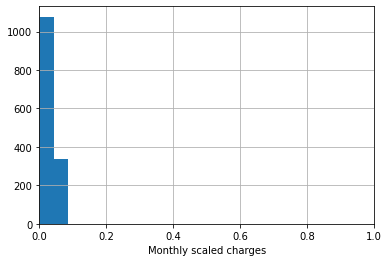

In [253]:
full_train_dataset_short_scaled_encoded[
    full_train_dataset_short_scaled_encoded['InternetService_Fiber optic'].isna()
]['MonthlyCharges'].hist(bins=2)
plt.xlabel('Monthly scaled charges')
plt.xlim(0, 1);

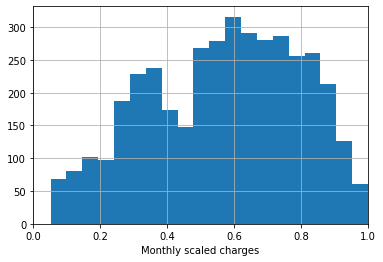

In [254]:
full_train_dataset_short_scaled_encoded[
    ~full_train_dataset_short_scaled_encoded['InternetService_Fiber optic'].isna()
]['MonthlyCharges'].hist(bins=20)
plt.xlabel('Monthly scaled charges')
plt.xlim(0, 1);

Well, the distributions of the monthly charged for the two groups do actually support the assumption that we just do not have data on the internet services usage since the corresponding customers do not have them in their package: they pay much less. Let's compare other variables.

In [255]:
full_train_dataset_short_scaled_encoded['internet_yes'] = np.where(
    full_train_dataset_short_scaled_encoded['InternetService_Fiber optic'].isna(), 0, 1
)

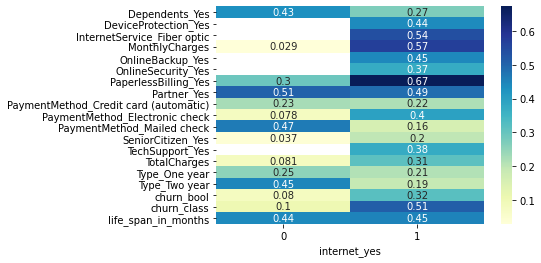

In [256]:
internet_stat = full_train_dataset_short_scaled_encoded.pivot_table(columns='internet_yes', aggfunc='mean')
sns.heatmap(
        data = internet_stat, cmap="YlGnBu",
        annot=True)
plt.show()

We remember that the other variables have values zero or one; thus, the average effectively means the percentage of the observations having value `1` for the corresponding variable. E.g. 67% of those for whom we **do** have data on the usage of the internet services signed up for paperless billing and 37% of them are senior sitizens, while among those for whom we **do not** have the data on the internet services, 29% signed up for paperless billing, though only 3.4% of them are senior citizens. This two groups also have different churn rates, 31% vs. 7.4%.

Let's try and assume that customers with missing data on the internet services just did not signed up for them (N.B. This assumption would be normally checked with the data engineers who provided us with the data); this assumption allows us to fill the missing values with zeroes:

In [257]:
full_train_dataset_short_scaled_filled = full_train_dataset_short_scaled_encoded.fillna(0)
X_raw_train_filled = full_train_dataset_short_scaled_filled.drop(columns=['churn_bool', 'churn_class', 'internet_yes'])
Y_raw_train_filled = full_train_dataset_short_scaled_filled['churn_bool']
Y_raw_class_train_filled = full_train_dataset_short_scaled_filled['churn_class']

Note: if we drop the missing values, we should proceed with the following datasets:

    full_train_dataset_short_scaled_dropna = full_train_dataset_short_scaled.dropna()
    X_raw_train_dropna = full_train_dataset_short_scaled_dropna.drop(columns=['churn_bool', 'churn_class', 'internet_yes'])
    Y_raw_train_dropna = full_train_dataset_short_scaled_dropna['churn_bool']
    Y_raw_class_train_dropna = full_train_dataset_short_scaled_dropna['churn_class']

Let's also fill in the missing values in the test subset:

In [258]:
full_test_dataset_short_scaled_filled = full_test_dataset_short_scaled_encoded.fillna(0)
X_raw_test_filled = full_test_dataset_short_scaled_filled.drop(columns=['churn_bool', 'churn_class'])
Y_raw_test_filled = full_test_dataset_short_scaled_filled['churn_bool']
Y_raw_class_test_filled = full_test_dataset_short_scaled_filled['churn_class']

[Back to Content](#content)

#### Logistic Regression

In [259]:
lr_short_scores = run_model(LogisticRegression(class_weight='balanced'), X_raw_train_filled, Y_raw_train_filled)

LogisticRegression(class_weight='balanced') results:
fit_time: [0.02, 0.02, 0.06, 0.02, 0.07, 0.02, 0.06, 0.02, 0.06, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.95, 0.93, 0.94, 0.94, 0.92, 0.91, 0.89, 0.84, 0.8, 0.71]
test_accuracy: [0.74, 0.86, 0.87, 0.85, 0.8, 0.72, 0.73, 0.65, 0.55, 0.35]
test_recall: [0.02, 0.53, 0.75, 0.87, 0.86, 0.93, 0.92, 0.97, 0.96, 1.0]
average roc_auc score: 0.89
average accuracy score: 0.72
average recall score: 0.79


In [260]:
append_model_stats(
    tuned_model_stat,
    'Logistic Regression | balanced',
    lr_short_scores['test_roc_auc'].mean(),
    lr_short_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced'],
 'roc_auc_score': [0.5850659060852006, 0.8880675126456534],
 'accuracy_score': [0.5464936692211306, 0.7177632171017562]}

In [261]:
rs_lr_tuned = tune_model(LogisticRegression(), X_raw_train_filled, Y_raw_train_filled, lr_param_space)

Best parameters: {'model__C': 0.09416777190511023, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__random_state': 42, 'model__solver': 'liblinear'}
Best score: 0.8904591135852351


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/jovyan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.

In [262]:
rs_lr_tuned.best_params_

{'model__C': 0.09416777190511023,
 'model__class_weight': 'balanced',
 'model__penalty': 'l1',
 'model__random_state': 42,
 'model__solver': 'liblinear'}

In [263]:
lr_tuned_best_model = LogisticRegression(**modify_dict(rs_lr_tuned.best_params_, '', left_trim=len('model__')))

In [264]:
lr_tuned_scores = run_model(lr_tuned_best_model, X_raw_train_filled, Y_raw_train_filled)

LogisticRegression(C=0.09416777190511023, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear') results:
fit_time: [0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]
score_time: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_roc_auc: [0.94, 0.95, 0.95, 0.94, 0.92, 0.91, 0.89, 0.84, 0.8, 0.7]
test_accuracy: [0.75, 0.87, 0.88, 0.85, 0.8, 0.73, 0.74, 0.65, 0.56, 0.37]
test_recall: [0.03, 0.56, 0.77, 0.89, 0.86, 0.93, 0.94, 0.97, 0.97, 1.0]
average roc_auc score: 0.89
average accuracy score: 0.73
average recall score: 0.80


In [265]:
append_model_stats(
    tuned_model_stat,
    'Logistic Regression | balanced | tuned',
    lr_tuned_scores['test_roc_auc'].mean(),
    lr_tuned_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned'],
 'roc_auc_score': [0.5850659060852006, 0.8880675126456534, 0.8904591135852351],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764]}

[Back to Content](#content)

#### Random Forest

In [266]:
rf_short_scores = run_model(RandomForestClassifier(), X_raw_train_filled, Y_raw_train_filled)

RandomForestClassifier() results:
fit_time: [0.36, 0.37, 0.39, 0.36, 0.36, 0.35, 0.36, 0.37, 0.36, 0.36]
score_time: [0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.01]
test_roc_auc: [0.74, 0.4, 0.44, 0.43, 0.52, 0.54, 0.63, 0.72, 0.77, 0.74]
test_accuracy: [0.74, 0.7, 0.68, 0.61, 0.61, 0.6, 0.65, 0.46, 0.45, 0.28]
test_recall: [0.0, 0.0, 0.01, 0.02, 0.13, 0.29, 0.47, 0.86, 0.9, 1.0]
average roc_auc score: 0.60
average accuracy score: 0.58
average recall score: 0.37


In [267]:
append_model_stats(
    tuned_model_stat,
    'Random Forest | balanced',
    rf_short_scores['test_roc_auc'].mean(),
    rf_short_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212]}

In [268]:
rs_rf_tuned = tune_model(RandomForestClassifier(), X_raw_train_filled, Y_raw_train_filled, rf_param_space)

Best parameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 28, 'model__min_samples_leaf': 26, 'model__min_samples_split': 5, 'model__n_estimators': 96}
Best score: 0.8439773908235295


In [269]:
rs_rf_tuned.best_params_

{'model__bootstrap': True,
 'model__class_weight': 'balanced',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': 28,
 'model__min_samples_leaf': 26,
 'model__min_samples_split': 5,
 'model__n_estimators': 96}

In [270]:
rf_tuned_best_model = RandomForestClassifier(**modify_dict(rs_rf_tuned.best_params_, '', left_trim=len('model__')))

In [271]:
rf_tuned_scores = run_model(rf_tuned_best_model, X_raw_train_filled, Y_raw_train_filled)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=28,
                       min_samples_leaf=26, min_samples_split=5,
                       n_estimators=96) results:
fit_time: [0.14, 0.17, 0.14, 0.14, 0.15, 0.16, 0.15, 0.14, 0.14, 0.14]
score_time: [0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]
test_roc_auc: [0.92, 0.88, 0.86, 0.81, 0.82, 0.84, 0.81, 0.81, 0.84, 0.78]
test_accuracy: [0.74, 0.82, 0.82, 0.77, 0.71, 0.66, 0.66, 0.47, 0.38, 0.28]
test_recall: [0.0, 0.38, 0.46, 0.53, 0.68, 0.86, 0.83, 1.0, 0.99, 1.0]
average roc_auc score: 0.84
average accuracy score: 0.63
average recall score: 0.68


In [272]:
append_model_stats(
    tuned_model_stat,
    'Random Forest | balanced | tuned',
    rf_tuned_scores['test_roc_auc'].mean(),
    rf_tuned_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085]}

[Back to Content](#content)

#### Keras implementation of Logistic Regression

In [273]:
X_raw_train_filled_t, X_raw_train_filled_v, Y_raw_train_filled_t, Y_raw_train_filled_v = train_test_split(
    X_raw_train_filled,
    Y_raw_train_filled,
    test_size=0.2,  
    stratify=Y_raw_train_filled,
    random_state=54321
)

In [274]:
keras_lr_tuned_with_val_data = keras_lr_with_val_data(
    X_raw_train_filled_t,
    Y_raw_train_filled_t,
    X_raw_train_filled_v,
    Y_raw_train_filled_v
)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 18        
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/300
135/135 [==============================] - 1s 3ms/step - loss: 1.8062 - auc_3: 0.4800 - accuracy: 0.4913 - val_loss: 0.6017 - val_auc_3: 0.4724 - val_accuracy: 0.7414
Epoch 2/300
135/135 [==============================] - 0s 1ms/step - loss: 1.7710 - auc_3: 0.4835 - accuracy: 0.4902 - val_loss: 0.5994 - val_auc_3: 0.4767 - val_accuracy: 0.7395
Epoch 3/300
135/135 [==============================] - 0s 2ms/step - loss: 1.7378 - auc_3: 0.4869 - accuracy: 0.4892 - val_loss: 0.5975 - val_auc_3: 0.4813 - val_accuracy: 0.73

In [275]:
keras_lr_tuned_with_val_data.history.keys()

dict_keys(['loss', 'auc_3', 'accuracy', 'val_loss', 'val_auc_3', 'val_accuracy'])

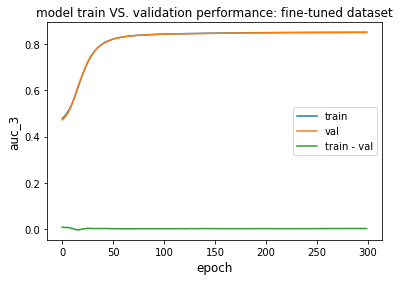

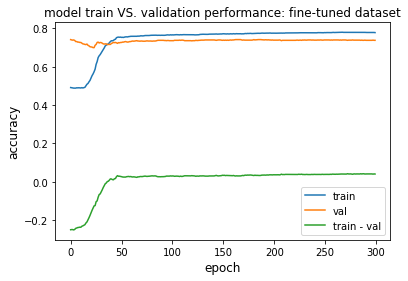

In [276]:
metrics_tuned = ['auc_3', 'accuracy']
for metric in metrics_tuned:
    plt.figure()
    plt.plot(keras_lr_tuned_with_val_data.history[metric])
    plt.plot(keras_lr_tuned_with_val_data.history["val_" + metric])
    plt.plot(
        [x - y for (x,y) in zip(keras_lr_tuned_with_val_data.history[metric],
                                keras_lr_tuned_with_val_data.history["val_" + metric])]
    )
    plt.title("model train VS. validation performance: fine-tuned dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

In [277]:
append_model_stats(
    tuned_model_stat,
    'Keras Logistic Regression | balanced | val_data',
    keras_lr_tuned_with_val_data.history[f'val_{metrics_tuned[0]}'][-1],
    keras_lr_tuned_with_val_data.history[f'val_{metrics_tuned[1]}'][-1]
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417]}

[Back to Content](#content)

#### HistGradientBoostingClassifier

Now, with the missing values treated we can also re-run the Histogram-nased Gradient Boosting Classification Tree, while balancing classes with the SMOTE method:

In [278]:
hgbc_raw_filled_data_scores = run_model_with_smote(
    HistGradientBoostingClassifier(
        learning_rate=0.01,
        #categorical_features = cat_cols,
        max_iter=200,
        random_state=42
    ),
    X_raw_train_filled,
    Y_raw_train_filled,
    to_scale=False  # we have already scaled the data in the numerical variable
)

HistGradientBoostingClassifier(learning_rate=0.01, max_iter=200,
                               random_state=42) results:
fit_time: [0.63, 0.66, 0.65, 0.63, 0.65, 0.67, 0.62, 0.65, 0.64, 0.63]
score_time: [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01]
test_roc_auc: [0.53, 0.71, 0.72, 0.62, 0.67, 0.68, 0.74, 0.63, 0.66, 0.57]
test_accuracy: [0.74, 0.66, 0.69, 0.58, 0.64, 0.6, 0.66, 0.54, 0.46, 0.27]
test_recall: [0.0, 0.05, 0.31, 0.57, 0.72, 0.78, 0.84, 0.94, 0.96, 1.0]
average roc_auc score: 0.66
average accuracy score: 0.59
average recall score: 0.62


In [279]:
append_model_stats(
    tuned_model_stat,
    'HistGradientBoosting | SMOTE balanced',
    hgbc_raw_filled_data_scores['test_roc_auc'].mean(),
    hgbc_raw_filled_data_scores['test_accuracy'].mean()
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data',
  'HistGradientBoosting | SMOTE balanced'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757,
  0.6581695284504662],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417,
  0.5880064796162074]}

[Back to Content](#content)

#### Comparing the results

"Basic" feature set:

In [280]:
pd.DataFrame(model_stat_basic).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.512985,0.625381
4,Random Forest | balanced,0.534945,0.591607
6,Keras Logistic Regression | balanced | val_split,0.734263,0.658296
5,Random Forest | balanced | tuned,0.820786,0.606687
7,Keras Logistic Regression | balanced | val_data,0.840755,0.747982
2,Logistic Regression | balanced,0.869221,0.701300
1,Logistic Regression | unbalanced,0.872294,0.781912
3,Logistic Regression | balanced | tuned,0.874748,0.693043


"Augmented" feature set:

In [281]:
pd.DataFrame(model_stat_augmented).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,Dummy Classifier,0.497206,0.592527
4,Random Forest | balanced,0.509269,0.534030
6,Keras Logistic Regression | balanced | val_split,0.699692,0.634074
5,Random Forest | balanced | tuned,0.821859,0.572300
2,Logistic Regression | balanced,0.873091,0.691849
1,Logistic Regression | unbalanced,0.873610,0.742617
3,Logistic Regression | balanced | tuned,0.883634,0.698672


"Tuned" feature set:

In [282]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
4,Random Forest | balanced | tuned,0.842532,0.634904
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
1,Logistic Regression | balanced,0.888068,0.717763
2,Logistic Regression | balanced | tuned,0.890459,0.725953


The following observations can be made here for the "tuned" feature set, with selected features and filled missing values:
1. `RandomForestClassifier` performed best if both `roc_auc` and `accuracy` are taken into account (after hyperparameter tuning);
2. The `HistGradientBoostingClassifier` resulted in the same `roc_auc` score and lower `accuracy` when SMOTE balancing method is used as without balancing;
3. `Keras` implementation of Logistic Regression still performs poorly, though much better result is achieved with class weightening and explicit use of a validation subset by passing it to the `validation_data` parameter, instead using the `validation_split` option.

In general, the balanced Logistic Regression model with hyperparameter tuning had the best `roc_auc` score of 0.88 on the "augmented" feature set and this feature set tend to result in slightly higher `roc_auc` scores for Logistc Regression models in general.

[Back to Content](#content)

### Two-class modeling - intermediate summary <a id='ml_intermediate'></a>

1. We established a baseline by running a Dummy Classifier model.
2. We trained a basic Logistic Regression, checked confusion tables and established the balancing procedure for the classes.
3. We trained 10+ models with class weightening and cross-validation: Logistic Regression (without and with hyperparameter tuning), Random Forest (without and with hyperparameter tuning) and the `keras` implementation of the Logistic Regression for two combinations of the preprocessed data: ("basic") contract and personal data and ("augmented") of contract, personal, internet services and multiple-phone service usage data.
4. We build additional `keras` implementation of Logistic Regression for the basic feature set, using `validation_data` option, instead of the `validation_split` parameter, and showed that it results in much higher scores. 
5. Then we tuned the feature dataset, by omitting less important features, as revealed during the `EDA` (including, multiple phone line service, gender, and streaming services); in addition, we dropped the last month of observations, since as we seen in the EDA part, those observations did not fit into the general pattern of the net number of custome IDs and we assumed this data can be preliminary in terms of the actual churn; the initial version of this feature set contained missing values for the internet services usage variables, since only part of the customer ID's are mentioned in the source file.
6. With the "tuned" feature set we trained `HistGradientBoosting`, without dropping the missing values (`HistGradientBoosting` Classifier handles them), which showed better result than the balanced Random Forest model on the "basic" feature set after hyperparameter tuning.
7. At the next step, we performed several checks and assumed that the missing values in the "tuned" feature set can be filled with zeros.
8. We re-run the Logistic Regression and the Random Forest models without and with hyperparameter tuning, as well as the `keras` implementation of the Logistic Regression and Histogram-based Gradient Boosting Classification Tree.
9. The best result (for the balanced weights) was achieved with the tuned Logistic Regression model on the "augmented" feature set (the combination of all source features without omitting the less important variables), which resulted in the `roc_auc` score of 0.88 and `accuracy` of 0.70.

The poor results of the `keras` version of the Logistic Regression and [this demo example](http://playground.tensorflow.org/#activation=tanh&batchSize=13&dataset=spiral&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=8,4,1&seed=0.16584&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=true&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) give a hint that we may actually be dealing with a complex non-linear dependency between the variables. Hence, in what follows, we propose to use the `Uniform Manifold Approximation (UMAP)` approach for non-linear dimension reduction ([here](https://umap-learn.readthedocs.io/en/latest/index.html) one can read about the theoretical assumtions involved) as a mean for further data exploration. As for now, we are interested in fine-tuning our EDA.

[Back to Content](#content)

## Taking a deeper look at the feature space with UMAP <a id='umap'></a>

UMAP learns the [manifold](https://mathworld.wolfram.com/Manifold.html) structure of the data and finds a low dimensional (2D or 3D) embedding that preserves the essential topological structure of that manifold. Let's import the necessary libraries.

In [283]:
pip install --user umap-learn

     |████████████████████████████████| 88 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 53.6 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=eb57bed92139c564d748c81328a144dd7aa7f63f4ec7bf163e03e92163ee46bc
  Stored in directory: /home/jovyan/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55497 sha256=ece0cf75fcaaad090f7558fac81a3a17f5d664c06f21e243acc5e7f4ce3a4b76
  Stored in directory: /home/jovyan/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Note: you may need to restart the kernel to use updated packages.


In [284]:
pip install --user bokeh 

     |████████████████████████████████| 16.4 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 11.2 MB/s  eta 0:00:01
     |████████████████████████████████| 296 kB 125.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [285]:
pip install --user datashader

     |████████████████████████████████| 18.2 MB 36.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 109.5 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 11.1 MB/s  eta 0:00:01
     |████████████████████████████████| 86 kB 11.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 76.1 MB/s eta 0:00:01
     |████████████████████████████████| 963 kB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 68.7 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 13.6 MB/s  eta 0:00:01
     |████████████████████████████████| 138 kB 126.3 MB/s eta 0:00:01
     |████████████████████████████████| 918 kB 75.7 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 110.2 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 88.1 MB/s eta 0:00:01
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59427 sha256=778dd4

In [286]:
pip install --user holoviews

     |████████████████████████████████| 4.3 MB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.2 MB/s s eta 0:00:01
     |████████████████████████████████| 17.3 MB 114.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [287]:
pip install --user scikit-image

     |████████████████████████████████| 14.0 MB 33.4 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 131.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 105.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 115.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 70.5 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [288]:
pip install --user colorcet

Note: you may need to restart the kernel to use updated packages.


In [289]:
import umap.umap_ as umap

In [290]:
import umap.plot # umap.plot requires pandas matplotlib datashader, bokeh, holoviews, scikit-image, and colorcet to be installed

To find a low dimensional representation of the data, we can use the `fit_transform()` method on a UMAP object. Let's try to find the embeddings for our tuned feature set (with filled missing values):

In [291]:
reducer = umap.UMAP(random_state=42)

In [292]:
raw_embedding = reducer.fit_transform(X_raw_train_filled)

In [293]:
raw_embedding.shape

(5372, 2)

The result is an array with only two feature columns (instead of the four we started with). This is because, by default, `UMAP` reduces down to 2D. Each row of the array is a 2-dimensional representation of the corresponding customer. Let's visualize the result. To this end, we will plot a scatterplot of the observations projected on the two axes of the embeddings.

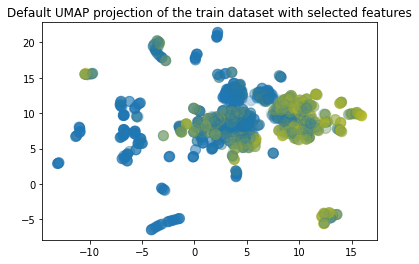

In [294]:
plt.scatter(
    raw_embedding[:, 0],
    raw_embedding[:, 1],
    c=[sns.color_palette()[x] for x in Y_raw_train_filled.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('Default UMAP projection of the train dataset with selected features', fontsize=12);

We can distinguish areas where more olive points (`churn_bool=1`) and with more blue points (`churn_bool=0`). Let's try various values of the `n_neighbors` parameter. This parameter defaults to 15 and "controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader view of the data." [Source](https://umap-learn.readthedocs.io/en/latest/parameters.html) We will ise the `min_dist` parameter value of zero, to allow for the most packed of the points in the low (here, `2D`) dimensional representation.

In [295]:
embedding_30_neighbors = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_raw_train_filled)

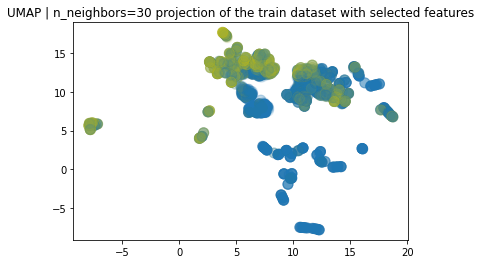

In [296]:
plt.scatter(embedding_30_neighbors[:, 0], embedding_30_neighbors[:, 1],
            c=[sns.color_palette()[x] for x in Y_raw_train_filled.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('UMAP | n_neighbors=30 projection of the train dataset with selected features', fontsize=12);

In [297]:
embedding_50_neighbors = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_raw_train_filled)

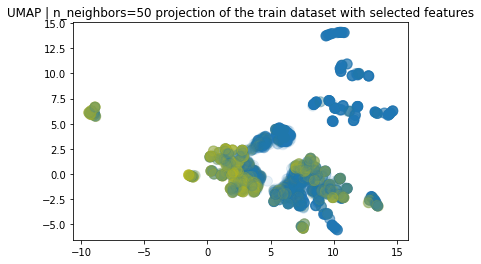

In [298]:
plt.scatter(embedding_50_neighbors[:, 0], embedding_50_neighbors[:, 1],
            c=[sns.color_palette()[x] for x in Y_raw_train_filled.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('UMAP | n_neighbors=50 projection of the train dataset with selected features', fontsize=12);

As we can see, as the `n_neighbor` parameter value growths the projection becomes more defined. One interesting observation: with `n_neighbor=15`, the two classes cannot be unambiguously devided into two separate clusters by churn: there are observations of both labels in each of the groupings. As the value of `n_neighbor` growths, two more dense clusters, as well as indication appear to some unusual observations (while preparing the datam we checked the only numerical variable we could have outliers in, `TotalCharges` and did not find explicit outliers). This embedding, for the `X_raw_train_filled` feature set, also provides a more connected projection. Let's compare it to an embedding for the `X_basic_train` feature sets: it can be the case that we will better understand the reasons why the modeling worked differently for them.

In [299]:
embedding_basic = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_basic_train_normalized)

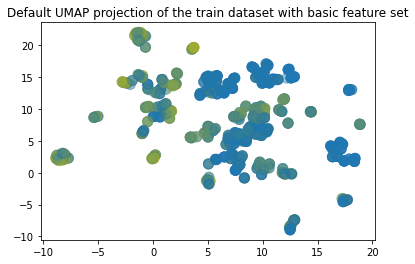

In [300]:
plt.scatter(embedding_basic[:, 0], embedding_basic[:, 1],
            c=[sns.color_palette()[x] for x in Y_basic_train.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('Default UMAP projection of the train dataset with basic feature set', fontsize=12);

Well, this projection of the basic feature set is closer to the default projection of the `X_raw_train_filled` feature set even with `n_neighbors=50`.

Now, let's check the `X_augmented_train` feature sets:

In [301]:
embedding_augmented = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_augmented_train_normalized)

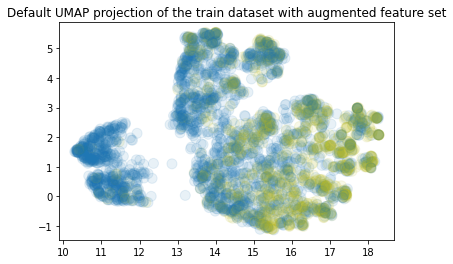

In [302]:
plt.scatter(embedding_augmented[:, 0], embedding_augmented[:, 1],
            c=[sns.color_palette()[x] for x in Y_augmented_train.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('Default UMAP projection of the train dataset with augmented feature set', fontsize=12);

This one actually shows a very different picture: there are four different clusters, two similar ones, one of which contains more observations and more churned customers, and another one which almost does not contain churned customers. In general, it gives some clues to the reasons the "augmented" dataset can work better.

Let's check whether dropping the observations for which we do not have data on the internet services usage result in better embeddings.

In [303]:
full_train_dataset_short_scaled_dropna = full_train_dataset_short_scaled_encoded.dropna()
X_raw_train_dropna = full_train_dataset_short_scaled_dropna.drop(columns=['churn_bool', 'churn_class', 'internet_yes'])
Y_raw_train_dropna = full_train_dataset_short_scaled_dropna['churn_bool']
Y_raw_class_train_dropna = full_train_dataset_short_scaled_dropna['churn_class']

In [304]:
embedding_50_neighbors_dropna = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_raw_train_dropna)

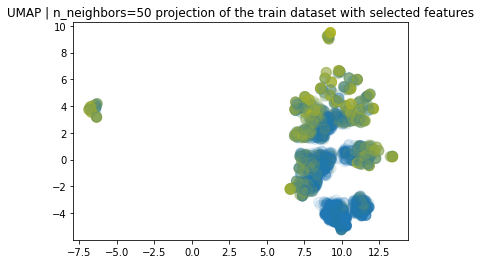

In [305]:
plt.scatter(embedding_50_neighbors_dropna[:, 0], embedding_50_neighbors_dropna[:, 1],
            c=[sns.color_palette()[x] for x in Y_raw_train_dropna.map({0:0, 1:8})], s = 100, alpha=0.1)
plt.title('UMAP | n_neighbors=50 projection of the train dataset with selected features', fontsize=12);

This one, naturally, resembles more the last plot, with embeddings received for the "augmented" feature set, while having a less fuzzy structure (as the result of omitting of, as we suggested, less important variables) with three different groupings: with no churn, with moderate churn and with "active" churn; also, two small groups of what can be unusual observations can be spotted on the plot. This grouping suggests that maybe we should apply three-class modeling. Let's color these embedding according to the three-class target variable and check the difference; in the same order:

"Tuned" feature set with filled missing values embeddings by three classes:

In [306]:
X_raw_train_filled.shape

(5372, 17)

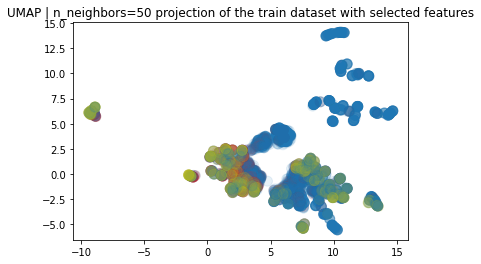

In [307]:
plt.scatter(embedding_50_neighbors[:, 0], embedding_50_neighbors[:, 1],
            c=[sns.color_palette()[x] for x in Y_raw_class_train_filled.map({0:0, 1:8, 2:3})], s = 100, alpha=0.1)
plt.title('UMAP | n_neighbors=50 projection of the train dataset with selected features', fontsize=12);

"Augmented" feature set embeddings by three classes:

In [308]:
X_augmented_train_normalized.shape

(3372, 21)

In [309]:
X_augmented_train_normalized.columns

Index(['MonthlyCharges', 'TotalCharges', 'life_span_in_months',
       'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

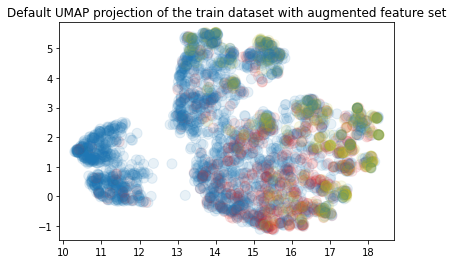

In [310]:
plt.scatter(embedding_augmented[:, 0], embedding_augmented[:, 1],
            c=[sns.color_palette()[x] for x in Y_augmented_class_train.map({0:0, 1:8, 2:3})], s = 100, alpha=0.1)
plt.title('Default UMAP projection of the train dataset with augmented feature set', fontsize=12);

"Tuned" feature set with dropped missing values embeddings by classes:

In [311]:
X_raw_train_dropna.shape

(3960, 17)

In [312]:
X_raw_train_dropna.columns

Index(['MonthlyCharges', 'TotalCharges', 'life_span_in_months',
       'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes'],
      dtype='object')

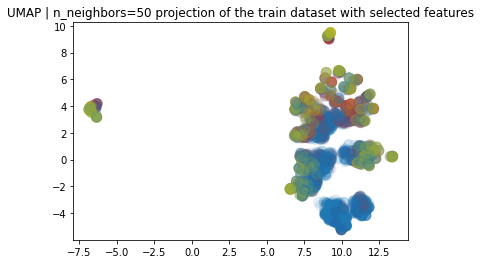

In [313]:
plt.scatter(embedding_50_neighbors_dropna[:, 0], embedding_50_neighbors_dropna[:, 1],
            c=[sns.color_palette()[x] for x in Y_raw_class_train_dropna.map({0:0, 1:8, 2:3})], s = 100, alpha=0.1)
plt.title('UMAP | n_neighbors=50 projection of the train dataset with selected features', fontsize=12);

From the last three plots, we can suggest, that three-class model will possibly harvest good results. In what follows, we will continue with the "tuned" dataset, as containing more observations and providing a more connected distribution of the features.

[Back to Content](#content)

## Constructing a better neural network model <a id='nn'></a>

Let's modify a bit the logistic regression neural network model and apply it to the "tuned" dataset.

### 3 Dense Layers

The "tuned" feature set contains 17 features; thus, we can choose to put x2 neurons into the input layer. Then we can shrink the number of neurons to the feature number and to complete the model with the regular logistic regression layer with 1 neuron and `sigmoid` activation function.

In [314]:
def nn_3dense_with_val_data(X_t,y_t, X_v, Y_v):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.25}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1]*2, input_dim=X_t.shape[1], activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1], activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dense(
            units=1, activation='sigmoid'
        )
    )
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X_t, y_t, epochs=300, verbose=1, validation_data=(X_v, Y_v), shuffle=True, class_weight=class_weight_dict)
    
    return model.history

In [315]:
nn_3dense_tuned_with_val_data = nn_3dense_with_val_data(
    X_raw_train_filled_t,
    Y_raw_train_filled_t,
    X_raw_train_filled_v,
    Y_raw_train_filled_v
)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 34)                612       
                                                                 
 dense_5 (Dense)             (None, 17)                595       
                                                                 
 dense_6 (Dense)             (None, 1)                 18        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/300
135/135 [==============================] - 1s 3ms/step - loss: 1.4064 - auc_4: 0.5139 - accuracy: 0.5004 - val_loss: 0.6598 - val_auc_4: 0.6254 - val_accuracy: 0.6065
Epoch 2/300
135/135 [==============================] - 0s 2ms/step - loss: 1.3446 - a

In [316]:
nn_3dense_tuned_with_val_data.history.keys()

dict_keys(['loss', 'auc_4', 'accuracy', 'val_loss', 'val_auc_4', 'val_accuracy'])

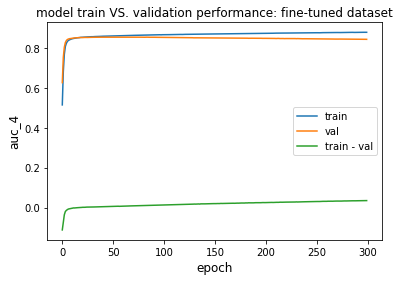

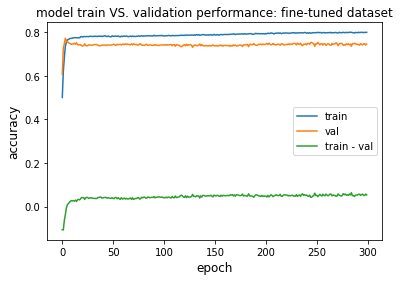

In [317]:
metrics_nn = ['auc_4', 'accuracy']
for metric in metrics_nn:
    plt.figure()
    plt.plot(nn_3dense_tuned_with_val_data.history[metric])
    plt.plot(nn_3dense_tuned_with_val_data.history["val_" + metric])
    plt.plot(
        [x - y for (x,y) in zip(nn_3dense_tuned_with_val_data.history[metric],
                                nn_3dense_tuned_with_val_data.history["val_" + metric])]
    )
    plt.title("model train VS. validation performance: fine-tuned dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

In this case, the model starts to overfit after 50 epochs.

In [318]:
append_model_stats(
    tuned_model_stat,
    '3-Dense layers NN | balanced | val_data',
    nn_3dense_tuned_with_val_data.history[f'val_{metrics_nn[0]}'][-1],
    nn_3dense_tuned_with_val_data.history[f'val_{metrics_nn[1]}'][-1]
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data',
  'HistGradientBoosting | SMOTE balanced',
  '3-Dense layers NN | balanced | val_data'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757,
  0.6581695284504662,
  0.8419627547264099],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417,
  0.5880064796162074,
  0.7451162934303284]}

In [319]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
7,3-Dense layers NN | balanced | val_data,0.841963,0.745116
4,Random Forest | balanced | tuned,0.842532,0.634904
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
1,Logistic Regression | balanced,0.888068,0.717763
2,Logistic Regression | balanced | tuned,0.890459,0.725953


### 3 Dense and 2 Dropout Layers

To treat the overfitting, we can try another model, with dropouts:

In [320]:
def nn_3dense_drop_with_val_data(X_t,y_t, X_v, Y_v):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.25}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1]*2, input_dim=X_t.shape[1], activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dropout(0.5)
    )
    
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1]*2, activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dropout(0.5)
    )
    
    model.add(
        keras.layers.Dense(
            units=1, activation='sigmoid'
        )
    )
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X_t, y_t, epochs=300, verbose=1, validation_data=(X_v, Y_v), shuffle=True, class_weight=class_weight_dict)
    
    return model.history

In [321]:
nn_3dense_drop_tuned_with_val_data = nn_3dense_drop_with_val_data(
    X_raw_train_filled_t,
    Y_raw_train_filled_t,
    X_raw_train_filled_v,
    Y_raw_train_filled_v
)

{0: 1.3333333333333333, 1: 4.0}
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 34)                612       
                                                                 
 dropout (Dropout)           (None, 34)                0         
                                                                 
 dense_8 (Dense)             (None, 34)                1190      
                                                                 
 dropout_1 (Dropout)         (None, 34)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 35        
                                                                 
Total params: 1,837
Trainable params: 1,837
Non-trainable params: 0
_________________________________________________________________
Model summary: None


In [322]:
nn_3dense_drop_tuned_with_val_data.history.keys()

dict_keys(['loss', 'auc_5', 'accuracy', 'val_loss', 'val_auc_5', 'val_accuracy'])

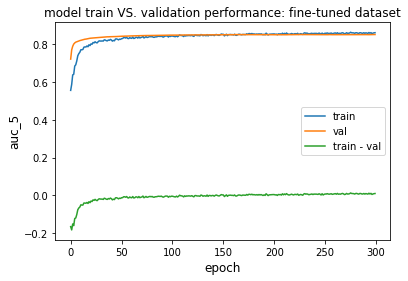

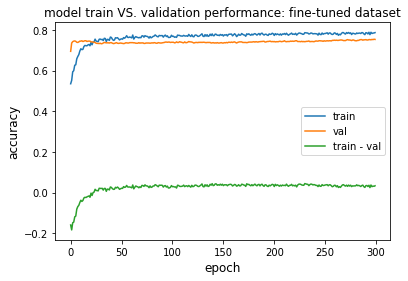

In [323]:
metrics_nn_drop = ['auc_5', 'accuracy']
for metric in metrics_nn_drop:
    plt.figure()
    plt.plot(nn_3dense_drop_tuned_with_val_data.history[metric])
    plt.plot(nn_3dense_drop_tuned_with_val_data.history["val_" + metric])
    plt.plot(
        [x - y for (x,y) in zip(nn_3dense_drop_tuned_with_val_data.history[metric],
                                nn_3dense_drop_tuned_with_val_data.history["val_" + metric])]
    )
    plt.title("model train VS. validation performance: fine-tuned dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

This model actually treats the overfitting.

In [324]:
append_model_stats(
    tuned_model_stat,
    '3-Dense layers with Drop NN | balanced | val_data',
    nn_3dense_drop_tuned_with_val_data.history[f'val_{metrics_nn_drop[0]}'][-1],
    nn_3dense_drop_tuned_with_val_data.history[f'val_{metrics_nn_drop[1]}'][-1]
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data',
  'HistGradientBoosting | SMOTE balanced',
  '3-Dense layers NN | balanced | val_data',
  '3-Dense layers with Drop NN | balanced | val_data'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757,
  0.6581695284504662,
  0.8419627547264099,
  0.8502076268196106],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417,
  0.5880064796162074,
  0.7451162934303284,
  0.7534883618354797]}

In [325]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
7,3-Dense layers NN | balanced | val_data,0.841963,0.745116
4,Random Forest | balanced | tuned,0.842532,0.634904
8,3-Dense layers with Drop NN | balanced | val_data,0.850208,0.753488
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
1,Logistic Regression | balanced,0.888068,0.717763
2,Logistic Regression | balanced | tuned,0.890459,0.725953


[Back to Content](#content)

### Simple three-class NN <a id='3class_nn'></a>

Let's check the class imbalance:

In [326]:
Y_raw_class_train.value_counts(normalize=True)

0    0.742740
2    0.146128
1    0.111132
Name: churn_class, dtype: float64

In [327]:
X_raw_train_filled_t3, X_raw_train_filled_v3, Y_raw_train_filled_t3, Y_raw_train_filled_v3 = train_test_split(
    X_raw_train_filled,
    Y_raw_class_train_filled,
    test_size=0.2,  
    stratify=Y_raw_class_train_filled,
    random_state=54321
)

In [328]:
def nn_simple_3class_with_val_data(X_t,y_t, X_v, Y_v):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.16, 2: 1/0.09}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1]*2, input_dim=X_t.shape[1], activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dense(
            units=3, activation='softmax'
        )
    )
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X_t, y_t, epochs=300, verbose=1, validation_data=(X_v, Y_v), shuffle=True, class_weight=class_weight_dict)
    
    return model.history

In [329]:
nn_simple_3class_tuned_with_val_data = nn_simple_3class_with_val_data(
    X_raw_train_filled_t3,
    keras.utils.to_categorical(Y_raw_train_filled_t3, 3),
    X_raw_train_filled_v3,
    keras.utils.to_categorical(Y_raw_train_filled_v3, 3)
)

{0: 1.3333333333333333, 1: 6.25, 2: 11.11111111111111}
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 34)                612       
                                                                 
 dense_11 (Dense)            (None, 3)                 105       
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/300
135/135 [==============================] - 1s 3ms/step - loss: 4.0432 - auc_6: 0.4279 - accuracy: 0.2259 - val_loss: 1.0545 - val_auc_6: 0.6081 - val_accuracy: 0.4381
Epoch 2/300
135/135 [==============================] - 0s 2ms/step - loss: 3.7289 - auc_6: 0.5080 - accuracy: 0.2772 - val_loss: 1.0633 - val_auc_6: 0.5895 - val_accuracy: 0.3721
Epoch 3/300
135/135

In [330]:
nn_simple_3class_tuned_with_val_data.history.keys()

dict_keys(['loss', 'auc_6', 'accuracy', 'val_loss', 'val_auc_6', 'val_accuracy'])

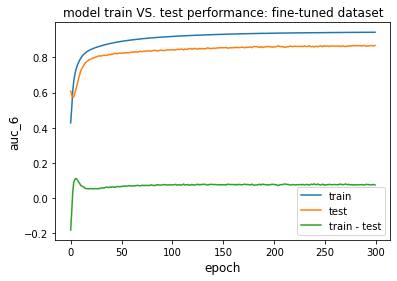

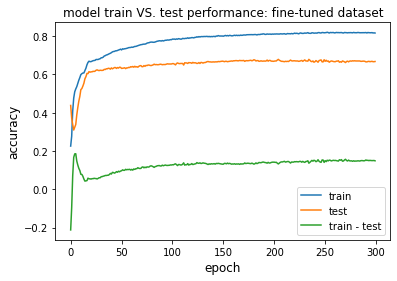

In [331]:
metrics_nn_3class = ['auc_6', 'accuracy']
for metric in metrics_nn_3class:
    plt.figure()
    plt.plot(nn_simple_3class_tuned_with_val_data.history[metric])
    plt.plot(nn_simple_3class_tuned_with_val_data.history["val_" + metric])
    plt.plot(
        [x - y for (x,y) in zip(nn_simple_3class_tuned_with_val_data.history[metric],
                                nn_simple_3class_tuned_with_val_data.history["val_" + metric])]
    )
    plt.title("model train VS. test performance: fine-tuned dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "test", "train - test"], loc="best")
    plt.show()
    plt.close()

This result does not look to be the best to converge and suggests that the class weightening part should be checked. Nevertheless, the `roc_auc` score is the same as for the tuned balanced Logistic Regression:

In [332]:
append_model_stats(
    tuned_model_stat,
    'Simple 3-class NN | balanced | val_data',
    nn_simple_3class_tuned_with_val_data.history[f'val_{metrics_nn_3class[0]}'][-1],
    nn_simple_3class_tuned_with_val_data.history[f'val_{metrics_nn_3class[1]}'][-1]
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data',
  'HistGradientBoosting | SMOTE balanced',
  '3-Dense layers NN | balanced | val_data',
  '3-Dense layers with Drop NN | balanced | val_data',
  'Simple 3-class NN | balanced | val_data'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757,
  0.6581695284504662,
  0.8419627547264099,
  0.8502076268196106,
  0.8680216670036316],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417,
  0.5880064796162074,
  0.7451162934303284,
  0.7534883618354797,
  0.6679069995880127]}

In [333]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
7,3-Dense layers NN | balanced | val_data,0.841963,0.745116
4,Random Forest | balanced | tuned,0.842532,0.634904
8,3-Dense layers with Drop NN | balanced | val_data,0.850208,0.753488
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
9,Simple 3-class NN | balanced | val_data,0.868022,0.667907
1,Logistic Regression | balanced,0.888068,0.717763
2,Logistic Regression | balanced | tuned,0.890459,0.725953


The three-class classification, even within a simple model, actually made a good job!

[Back to Content](#content)

## Best model discussion <a id='best_model'></a>

1. While trying to improve the results of the modeling, we turned to a deeper analysis of the differences between the three feature sets we have tried to model the data with.
2. Using UMAP embeddings visualizations, we concluded that continuing with the previousely "tuned" feature set should be a more prominent option.
3. We constructed 2 additional neural networks for the two-class classification case, which resulted in lower validation `roc_auc` score than the `keras` implementation of logistic regression.
4. Also, we constructed a simple three-class neural network, to demonstrate the potential; the model resulted in much better validation `roc_auc` score than the `keras` implementation of logistic regression; thus, a bit more comprehensive model would make even a better job.
5. Balanced Logistic Regression after hyperparameter tuning showed the best validation `roc_auc` score so far.

Despite we found a Logistic Regression model which showed a better validation `roc_auc` score, **usually Logistic Regression model show significantly lower performance on test dataset, while the last 3-class NN showed a very promissing result and is not expected to show lower performance**. Thus, we propose the latter as the final model.


To assess the performance of the best model, we will run it on the test subset and, based on the learning curves, choose 200 epochs to run as being a suffucient number.

In [336]:
def nn_simple_3class_with_test_data(X_t,y_t, X_v, Y_v):
    
    class_weight_dict = {0: 1/0.75, 1: 1/0.16, 2: 1/0.09}
    print(class_weight_dict)

    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=X_t.shape[1]*2, input_dim=X_t.shape[1], activation='relu'
        )
    )
    
    model.add(
        keras.layers.Dense(
            units=3, activation='softmax'
        )
    )
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # an optimizer with variable learning rate
        weighted_metrics=[keras.metrics.AUC(), 'accuracy']
    )
    print(f'Model summary: {model.summary()}')
    model.fit(X_t, y_t, epochs=200, verbose=1, validation_data=(X_v, Y_v), shuffle=True, class_weight=class_weight_dict)
    
    return model.history

In [337]:
nn_simple_3class_tuned_with_test_data = nn_simple_3class_with_test_data(
    X_raw_train_filled,
    keras.utils.to_categorical(Y_raw_train_filled, 3),
    X_raw_test_filled,
    keras.utils.to_categorical(Y_raw_test_filled, 3)
)

{0: 1.3333333333333333, 1: 6.25, 2: 11.11111111111111}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 34)                612       
                                                                 
 dense_13 (Dense)            (None, 3)                 105       
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________
Model summary: None
Epoch 1/200
168/168 [==============================] - 1s 3ms/step - loss: 2.6666 - auc_7: 0.6469 - accuracy: 0.4181 - val_loss: 0.9270 - val_auc_7: 0.7422 - val_accuracy: 0.4993
Epoch 2/200
168/168 [==============================] - 0s 2ms/step - loss: 2.3166 - auc_7: 0.7931 - accuracy: 0.5854 - val_loss: 0.8645 - val_auc_7: 0.7601 - val_accuracy: 0.5311
Epoch 3/200
168/168

In [338]:
nn_simple_3class_tuned_with_test_data.history.keys()

dict_keys(['loss', 'auc_7', 'accuracy', 'val_loss', 'val_auc_7', 'val_accuracy'])

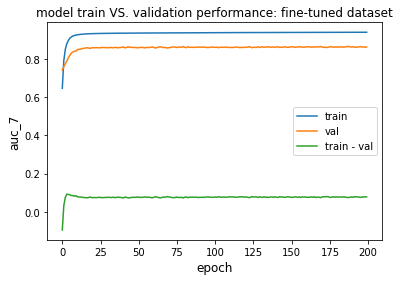

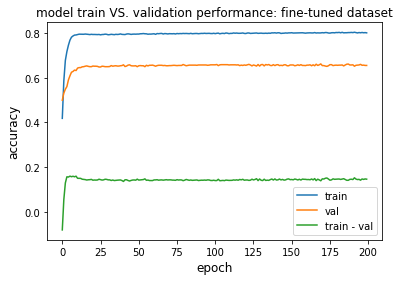

In [339]:
metrics_nn_3class_test = ['auc_7', 'accuracy']
for metric in metrics_nn_3class_test:
    plt.figure()
    plt.plot(nn_simple_3class_tuned_with_test_data.history[metric])
    plt.plot(nn_simple_3class_tuned_with_test_data.history["val_" + metric])
    plt.plot(
        [x - y for (x,y) in zip(nn_simple_3class_tuned_with_test_data.history[metric],
                                nn_simple_3class_tuned_with_test_data.history["val_" + metric])]
    )
    plt.title("model train VS. validation performance: fine-tuned dataset")
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val", "train - val"], loc="best")
    plt.show()
    plt.close()

In [340]:
append_model_stats(
    tuned_model_stat,
    'Simple 3-class NN | balanced | val_data -> test',
    nn_simple_3class_tuned_with_test_data.history[f'val_{metrics_nn_3class_test[0]}'][-1],
    nn_simple_3class_tuned_with_test_data.history[f'val_{metrics_nn_3class_test[1]}'][-1]
)

{'model_name': ['HistGradientBoosting | unbalanced | w/missing values',
  'Logistic Regression | balanced',
  'Logistic Regression | balanced | tuned',
  'Random Forest | balanced',
  'Random Forest | balanced | tuned',
  'Keras Logistic Regression | balanced | val_data',
  'HistGradientBoosting | SMOTE balanced',
  '3-Dense layers NN | balanced | val_data',
  '3-Dense layers with Drop NN | balanced | val_data',
  'Simple 3-class NN | balanced | val_data',
  'Simple 3-class NN | balanced | val_data -> test'],
 'roc_auc_score': [0.5850659060852006,
  0.8880675126456534,
  0.8904591135852351,
  0.5987398639440851,
  0.8425316824017086,
  0.8514720797538757,
  0.6581695284504662,
  0.8419627547264099,
  0.8502076268196106,
  0.8680216670036316,
  0.8630882501602173],
 'accuracy_score': [0.5464936692211306,
  0.7177632171017562,
  0.7259534242971764,
  0.5833433712003212,
  0.6349044325836085,
  0.7376744151115417,
  0.5880064796162074,
  0.7451162934303284,
  0.7534883618354797,
  0.66790

In [341]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
7,3-Dense layers NN | balanced | val_data,0.841963,0.745116
4,Random Forest | balanced | tuned,0.842532,0.634904
8,3-Dense layers with Drop NN | balanced | val_data,0.850208,0.753488
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
10,Simple 3-class NN | balanced | val_data -> test,0.863088,0.654910
9,Simple 3-class NN | balanced | val_data,0.868022,0.667907
1,Logistic Regression | balanced,0.888068,0.717763


Our final model showed `roc_auc` score of 0.86.

[Back to Content](#content)

## Conclusions <a id='conclusions'></a>

In this project, the telecom operator Interconnect wanted to be able to forecast their churn of clients. If a user is detected as one who is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has four source files to build the forecasting model:
- `contract.csv` which includes variables on the start and the end (if any) contract and some billing information;
- `personal.csv` which includes personal data about the customers - their gender, age group, presence of children and partner status;
- `internet.csv` and `phone.csv` which include boolean variables on usage for different services, though the data cover less customers and there is no indication on the start date of usage (which may be of interest as well).

As part of EDA, we demonstrated that the most churn happened during the first three months of the contract and with the customers with higher monthly charges, while the customers can be devided not only into those who churned and those who not, but into three classes, when churned customers are grouped as those who churned in the first 6 months of the contract and those who churned after a longer period.

In addition, we discovered the following issues with the source data:
- partial data on internet and phone services usage as compared to the number of customer IDs covered by the contract and personal information; no indication on the months customers had singed up for additional services;
- the data cover the churn period of four months, from Oct 2019 to Jan 2020;
- there were more new customers and more churn in the last five months of the period.

Regarding the modeling, together with the team leader, we ended up with the following plan:
- try modeling with two datasets, a "basic" one, which includes data from `contract.csv` and from `perdonal.csv`, and an "augmented" one, which uses the data of all the source files;
- consider the task as being a two-class classification problem and a three-class classification problem;
- apply Logistic Regression as a base model, then try Random Forest, and some variation of a neural network.

The need to prevent data leakage (any `EndDate` based variables are target) and avoid multicollinearity while encoding was stressed.

The modeling itself included:
- finalization of the dataset preprocessing (correct data types assignment, datasets join, categorical variables encoding ([see the note on encoding](#encoding_note)));
- dataset split into training and testing subsets ([see the note on splitting](#split_note)); validation subset was extracted for weighted class NN models;
- scaling;
- training a number of models with cross-validation;
- the need of class balancing was studied separately (see below); the models were modified to include class weights (for weighted class NN models, it was shown that a better result can be achieved when a validation subset is split from the trainign set and explicitely passed to the `.fit()` method of the model);
- comparing the models by validation scores, choice of the best model and checking its performance on the test subset.

During the two-class modeling:
1. We established a baseline by running a Dummy Classifier model; trained a basic Logistic Regression, checked confusion tables and established the balancing procedure for the classes.
2. We trained 10+ models with class weightening and cross-validation: Logistic Regression (without and with hyperparameter tuning), Random Forest (without and with hyperparameter tuning) and the `keras` implementation of the Logistic Regression for two combinations of the preprocessed data: "basic" and "augmented".
3. We build additional `keras` implementation of Logistic Regression for the basic feature set, using `validation_data` option, instead of the `validation_split` parameter, and showed that it results in much higher scores. 
4. Then we tuned the feature dataset, by omitting less important features, as revealed during the `EDA` (multiple phone line service, gender, and streaming services); the initial version of this feature set contained missing values for the internet services usage variables, since only part of the customer ID's are mentioned in the source file.
5. With the "tuned" feature set we trained `HistGradientBoosting`, without dropping the missing values (`HistGradientBoosting` Classifier handles them), which showed better result than the balanced Random Forest model on the "basic" feature set after hyperparameter tuning.
6. At the next step, we performed several checks and assumed that the missing values in the "tuned" feature set can be filled with zeros, thus, preserving observations, as oposed to the "augmented" feature set.
7. We re-run the Logistic Regression and the Random Forest models without and with hyperparameter tuning, as well as the `keras` implementation of the Logistic Regression and Histogram-based Gradient Boosting Classification Tree.

The poor results of the `keras` version of the Logistic Regression suggested that we might have been actually dealing with a complex non-linear dependency between the variables. We used [`Uniform Manifold Approximation (UMAP)` approach for non-linear dimension reduction](https://umap-learn.readthedocs.io/en/latest/index.html), mainly as additional exploration tool.

The UMAP exploration resulted in two conclusions:
- the "tuned" feature dataset (see paragraph 4 above) with filled missing values comprises a more prominent option.
- a three-class model will possibly bring good results.

In what followed, based on the "tuned" feature set, we constructed:
- 2 additional neural networks for the two-class classification case, which resulted in lower validation `roc_auc` score than the `keras` implementation of logistic regression.
- a simple three-class neural network; the initial idea was to demonstrate the potential, while actually, even this simple model, harvested a good result in term of `roc_auc` score, and we decided to pic it as the final model.

Thus, the best result was achieved with a simple 3-class NN: the test `roc_auc` score of 0.86.

In [342]:
pd.DataFrame(tuned_model_stat).sort_values(by='roc_auc_score')

,model_name,roc_auc_score,accuracy_score
0,HistGradientBoosting | unbalanced | w/missing ...,0.585066,0.546494
3,Random Forest | balanced,0.598740,0.583343
6,HistGradientBoosting | SMOTE balanced,0.658170,0.588006
7,3-Dense layers NN | balanced | val_data,0.841963,0.745116
4,Random Forest | balanced | tuned,0.842532,0.634904
8,3-Dense layers with Drop NN | balanced | val_data,0.850208,0.753488
5,Keras Logistic Regression | balanced | val_data,0.851472,0.737674
10,Simple 3-class NN | balanced | val_data -> test,0.863088,0.654910
9,Simple 3-class NN | balanced | val_data,0.868022,0.667907
1,Logistic Regression | balanced,0.888068,0.717763


[Back to Content](#content)